# Methods for Computational Politics

## Introduction
The 21st century has brought with it a wealth of new methods for data collection and analysis. Due to the convergence of digital trace data availability, more transparent data and code sharing norms, and relatively cheap and plentiful computer processing capabilities, researchers with a laptop and an internet connection can now access a large and growing set of tools and methods. The implications of the "computational revolution" is profound for the study of social and political processes, but the skills required to collect and harness these new sources of data are typically not taught to social scientists. This code is for anyone who is interested in studying phenomena that are of social and political importance using the growing set of computational methods that are being used to understand these phenomena in new ways. While these processes are reasonably accessible, it is also critical to understand their limits especially in an adversarial problem space such as bot-detection.

## Part 1: Authentication, Tweet Extraction, and Bot Detection
The first part of the code examines how researchers can extract data from Twitter, a popular online news and social networking platform. While Twitter provides more access to its data than many other platforms, extracting data from Twitter's servers requires using its Application Programming Interface (or API). This part of the code will cover useful concepts when working with Twitter's API, including rate limiting and error handling, as well as methods for detecting whether Twitter users are humans or automated accounts (i.e. bots). This code is designed to run on Google's Colab for ease of access but you could just as easily run it locally on Jupyter notebooks.

Emmi Bevensee<br>
University of Arizona<br>
Email: emmibevensee@email.arizona.edu<br>

## 1. Importing libraries and authenticating Twitter

In [0]:

# Install necesarry packages
# !pip install tweepy
# !pip install seaborn
!pip install botometer

In [0]:
# Import the libraries we need
import tweepy

import botometer
import json
import time
import os
import pandas as pd
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import csv
import pickle

import re
from __future__ import print_function, unicode_literals

import traceback
import csv

In [0]:
# Check working directory
os.getcwd()

In [0]:
#get rid of this if you're running locally
from google.colab import drive
drive.mount('/content/drive')

In [0]:
# Change working directory to where you want it to be
os.chdir('change to your correct path')

# Check working directory
os.getcwd()

In [0]:

#get ya keys in order!
consumer_key = 'PUT YOUR KEY HERE'
consumer_secret = 'PUT YOUR KEY HERE'
access_token = 'PUT YOUR KEY HERE'
access_token_secret = 'PUT YOUR KEY HERE'

#https://rapidapi.com/OSoMe/api/botometer
mashape_key = 'PUT YOUR KEY HERE'


# Authenticate
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth, wait_on_rate_limit= True, wait_on_rate_limit_notify=True) #added these waiting calls

In [0]:
#sets a label for what the large election we are breaking down is
major_election = 'EU_parliament'

In [0]:
def botdetectfunction(election, leaning, hashtags):
    """## 2. Pulling relevant tweets"""

    # Keep track of API calls
    # For more information, visit https://developer.twitter.com/en/docs/basics/rate-limits.html
    calls = 0


    # Pulling most recent tweets (up to 100)
    tweets_raw = api.search(hashtags, count = 100, result_type='recent')
    calls += 1

    # Extract tweets from json wrapper
    tweets = [t._json for t in tweets_raw]

    # Print number of tweets collected
    len(tweets)

    # Print id, date/time, and user name of tweets
    for t in tweets[:5]:
            print(t['id_str'],t['created_at'],t['user']['screen_name'])

#     # Print last tweet
#     tweets[len(tweets)-1]

#     # Print id number of final tweet minus one
#     tweets[len(tweets)-1]['id']-1

    tweets_new = tweets

    # Pulling all tweets - usually bound to about a week
    while (calls < 180 & len(tweets_new) > 0):
        tweets_raw = api.search(hashtags, count = 100, result_type='recent',max_id=tweets_new[len(tweets_new)-1]['id']-1)
        calls += 1
        tweets_new = [t._json for t in tweets_raw]
        tweets = tweets + tweets_new

    # Number of API calls made
    calls

    # Total tweets pulled, this number gets used later as well for normalizing numbers of tweets
    numtweets = len(tweets)
    print('number of tweets')
    print(numtweets)
    if numtweets == 0:
      #prevents the code from breaking if no one is using the hashtag
      print("no tweets bro, try a different hashtag...")
      return
    else:

  #     # Least recent tweet
  #     tweets[len(tweets)-1]

  #     # Print id, date/time, user name, and retweet count for test
      for t in tweets[:5]:
              print(t['id_str'],t['created_at'],t['user']['screen_name'],t['retweet_count'])

      # Writing tweets to a json file              #[1:] leaves out the #  #change this is you want to use text instead of hashtags
      with open(str(major_election)+ '_' + str(election)+ '_' + str(hashtags[1:])+ '_' + str('tweets.json'), 'w') as file:
          json.dump(tweets, file)

      # Read saved tweets
      with open(str(major_election)+ '_' + str(election)+ '_' + str(hashtags[1:])+ '_' + str('tweets.json'), 'r') as file:
          tweets = json.load(file)


      alltweetsdf = pd.DataFrame(tweets)    

      # this will be to make sure you don't get the header every time
      # if file does not exist write header 
      if not os.path.isfile(str(major_election) + '_tweets_json.csv'):
        alltweetsdf.to_csv(str(major_election) + '_tweets_json.csv')
      else: # else it exists so append without writing the header
        alltweetsdf.to_csv(str(major_election) + '_tweets_json.csv', mode='a', header=False) #possibly need the header?

  #     alltweetsdf

      """## 3. Detecting automated accounts"""

      # Input Botometer authentication information - which includes Twitter authentication
      twitter_app_auth = {
          'consumer_key': consumer_key,
          'consumer_secret': consumer_secret,
          'access_token': access_token,
          'access_token_secret': access_token_secret,
        }

      # Authenticate Botometer
      bon = botometer.Botometer(wait_on_ratelimit=True,mashape_key=mashape_key,**twitter_app_auth)

      #this gets the sub-json we need from the larger json file
      users = [t['user'] for t in tweets]

      pd.set_option('display.max_columns', None)
      df = pd.DataFrame(users)

      bots = df[['id_str','screen_name',  'followers_count' ]]

      #creates a new column that counts how much a user tweets a given hashtag
      bots['activity'] = bots.groupby(['screen_name'])['id_str'].transform('count')

      bots = bots.set_index('id_str')



      bots = bots.drop_duplicates(subset=['screen_name'])

      bots = bots.sort_values(by='activity', ascending=False)

      bots['bot_score'] = pd.np.nan
      bots['hashtag'] = hashtags
      bots['election']= election
      bots['leaning']= leaning


      bots

      #you can change the number of users here but each one takes about 5 seconds
      num_users_to_score = 40
      unscored_rows = bots[bots['bot_score'].isnull()]
      rows_to_score = unscored_rows[:num_users_to_score]
      accounts_not_to_score = 0 #this is to not count accounts that weren't scored because of an error

      for num, (user_id, data) in enumerate(rows_to_score.iterrows()):
          print("Checking {current} of {total}, sn: {sn}, id: {uid}...".format(
                 current=num+1,
                 total=len(rows_to_score),
                 sn=data['screen_name'],
                 uid=user_id,
          ))
          retry = 0
          while True:
              try:
                  bon_result = bon.check_account(user_id)
                  #we've here selected the universal score rather than english specific but you can change this
                  bots.loc[user_id, 'bot_score'] = bon_result['scores']['universal']
                  print('    ...success!')
              except botometer.tweepy.TweepError:
                  accounts_not_to_score += bots.loc[user_id, 'activity'] #this is to not count accounts that weren't scored because of an error
                  print('    ...fail.')
              except requests.HTTPError:

                  accounts_not_to_score += bots.loc[user_id, 'activity'] #this is to not count accounts that weren't scored because of an error
                  print("ERROR")
                  traceback.print_exc()
                  break
                    #this used to sometimes turn into infinite loops so I cut it
  #                 secs = 2 ** retry
  #                 traceback.print_exc()
  #                 print('    ...error. Retrying in %i secs...' % secs)
  #                 retry += 1
  #             if 0 < retry <= 3:
  #                 time.sleep(secs)
              else:
                  break
      print("Done checking %i accounts." % num_users_to_score)

      table = bots.iloc[:num_users_to_score]

      table

      bot_scores = table[table['bot_score'].notnull()]['bot_score']
      sns.set(rc={"figure.figsize": (12, 6)})
      ax = sns.distplot(bot_scores, label = hashtags)
      ax.set_title('Bot-likelihood Scores for Active Hashtag Users')
  #     ax.set_title('Bot scores for top {N} most active accounts by number of tweets'
  #                  '\ncontaining {hashtags}'.format(
  #         N=num_users_to_score,
  #         #update if you want more hashtags
  #         hashtags=hashtags
  #         ))
      ax.set_xlim([0,1])
      ax.set_xlabel('Bot score')
      ax.yaxis.set_visible(False)
      ax.patch.set_visible(False)
#       ax.legend() #only looks good for a small number of hashtags.

      # safe_hashtag_list = ','.join(hashtags).replace('#', '')
      #more for lists of hashtags in different implementation
      filename = '_'.join(['active-users', hashtags])
      #saves image to your local folder
      plt.savefig(filename)
      #If you get a FutureWarning message about Anaconda, ignore it

      print("Mean: %0.2f, median: %0.2f" % (bot_scores.mean(), bot_scores.median()))

      #creates a new table of just the active and botlike accounts above the .7 threshold
      botliketable = table[(table['bot_score'] > .7)]

      botliketable = botliketable.sort_values(by= ['bot_score','activity'] , ascending=[False, False])

      #write to csv
      if not os.path.isfile(str(major_election) + '_botlike_active_accounts.csv'):
        botliketable.to_csv(str(major_election) + '_botlike_active_accounts.csv')
      else: # else it exists so append without writing the header
        botliketable.to_csv(str(major_election) + '_botlike_active_accounts.csv', mode= 'a', header=False)



      print(botliketable)

      tweetsbybots = botliketable.loc[:, 'activity'].sum()
      totaltweetsscored = table.loc[: , 'activity'].sum() - accounts_not_to_score #this is to not count accounts that weren't scored because of an error
      tweetsbyhumans = totaltweetsscored - tweetsbybots

      totalbotfollowers = botliketable.loc[:, 'followers_count'].sum()
      print("total bot followers " + str(totalbotfollowers))

      print(str(tweetsbyhumans) + ' tweets by humans and ' + str(tweetsbybots) + ' tweets by bots')
      print(str(round((tweetsbybots/totaltweetsscored), 2) * 100) + '% of tweets tested in ' + str(hashtags) + ' which is in the ' + leaning + ' grouping, are by bot-like accounts' )

      
      '''this is used to normalize the numbers of tweets and calculate relative sizes'''

       #initializing a local dictionary with no values.
      if not os.path.isfile('numtweets.pkl'):
        numtweetdict = {}
        numtweetdict[str(major_election) + '_total'] = 0
        numtweetdict[str(election)  + '_total'] =  0
        numtweetdict[str(leaning) + '_total'] =  0
        numtweetdict[str(hashtags) + '_total'] =  0

        numtweetdict[str(major_election) + '_bots'] = 0
        numtweetdict[str(election)  + '_bots'] = 0
        numtweetdict[str(leaning) + '_bots'] = 0
        numtweetdict[str(hashtags) +  '_bots'] = 0

        numtweetdict[str(major_election) + '_percent_bots'] = 0
        numtweetdict[str(election)  + '_percent_bots'] =  0
        numtweetdict[str(leaning) + '_percent_bots'] =  0
        numtweetdict[str(hashtags) + '_percent_bots']= 0


        numtweetdict[str(major_election) + '_bot_followers_total'] = 0
        numtweetdict[str(election)  + '_bot_followers_total'] =  0
        numtweetdict[str(leaning) + '_bot_followers_total'] =  0
        numtweetdict[str(hashtags) + '_bot_followers_total'] =  0
#         print(numtweetdict)

        with open('numtweets.pkl', 'wb') as f:
          pickle.dump(numtweetdict, f)


  #these create new key-value pairs if there isn't one and otherwise updates them with the new info
      with open('numtweets.pkl', 'rb') as f:
        numtweetdict = pickle.load(f)

      if str(major_election) + '_total' not in numtweetdict:
        numtweetdict[str(major_election) + '_total'] = totaltweetsscored
      else:
         numtweetdict[str(major_election) + '_total'] += totaltweetsscored
      if str(election) + '_total' not in numtweetdict:
        numtweetdict[str(election)  + '_total'] = totaltweetsscored
      else:
        numtweetdict[str(election)  + '_total'] += totaltweetsscored
      if str(leaning) + '_total' not in numtweetdict:
        numtweetdict[str(leaning) + '_total'] = totaltweetsscored
      else:
        numtweetdict[str(leaning) + '_total'] += totaltweetsscored
      if str(hashtags) + '_total' not in numtweetdict:
        numtweetdict[str(hashtags) + '_total'] = totaltweetsscored
      else:
        numtweetdict[str(hashtags) + '_total'] += totaltweetsscored

        

      if str(major_election) + '_bots' not in numtweetdict:
        numtweetdict[str(major_election) + '_bots'] = tweetsbybots
      else:
        numtweetdict[str(major_election) + '_bots'] += tweetsbybots
      if str(election)  + '_bots' not in numtweetdict:
        numtweetdict[str(election)  + '_bots'] = tweetsbybots
      else:
        numtweetdict[str(election)  + '_bots'] += tweetsbybots
      if str(leaning) + '_bots' not in numtweetdict:
        numtweetdict[str(leaning) + '_bots'] = tweetsbybots
      else:
        numtweetdict[str(leaning) + '_bots'] += tweetsbybots
      if str(hashtags) +  '_bots' not in numtweetdict:
        numtweetdict[str(hashtags) +  '_bots'] = tweetsbybots
      else:
        numtweetdict[str(hashtags) +  '_bots'] += tweetsbybots

        

      if str(major_election) + '_bot_followers_total' not in numtweetdict:
        numtweetdict[str(major_election) + '_bot_followers_total'] = totalbotfollowers
      else:
        numtweetdict[str(major_election) + '_bot_followers_total'] += totalbotfollowers
      if str(election) + '_bot_followers_total' not in numtweetdict:
        numtweetdict[str(election) + '_bot_followers_total'] = totalbotfollowers
      else:
        numtweetdict[str(election) + '_bot_followers_total'] += totalbotfollowers
      if str(leaning) + '_bot_followers_total' not in numtweetdict:
        numtweetdict[str(leaning) + '_bot_followers_total'] = totalbotfollowers
      else:
        numtweetdict[str(leaning) + '_bot_followers_total'] += totalbotfollowers
      if str(hashtags) + '_bot_followers_total' not in numtweetdict:
        numtweetdict[str(hashtags) + '_bot_followers_total'] = totalbotfollowers
      else:
        numtweetdict[str(hashtags) + '_bot_followers_total'] += totalbotfollowers

  #calculates percent that are bot-like

      numtweetdict[str(major_election) + '_percent_bots'] = (numtweetdict[str(major_election) + '_bots']/ numtweetdict[str(major_election) + '_total'])*100
      numtweetdict[str(election)  + '_percent_bots'] = (numtweetdict[str(election)  + '_bots']/ numtweetdict[str(election)  + '_total'])*100
      numtweetdict[str(leaning) + '_percent_bots'] = (numtweetdict[str(leaning) + '_bots'] /numtweetdict[str(leaning) + '_total'])*100
      numtweetdict[str(hashtags) + '_percent_bots'] = (numtweetdict[str(hashtags)  +  '_bots'] / numtweetdict[str(hashtags) + '_total'])*100

      with open('numtweets.pkl', 'wb') as f:
        pickle.dump(numtweetdict, f)


  #human readable final results
      numtweetlist = []
      for key, value in numtweetdict.items():
        numtweetlist.append((key,value))

      numtweetdf = pd.DataFrame(numtweetlist)
      numtweetdf.to_csv('numtweetdf.csv')

      print(numtweetdict)


#EuropaSolidarisch
far_left
1128094678480560128 Tue May 14 00:28:24 +0000 2019 LINKEGiessenKV
1128091535428468736 Tue May 14 00:15:55 +0000 2019 TheRealSuddel
1128082307682840579 Mon May 13 23:39:15 +0000 2019 ThatTakashi
1128078652783116288 Mon May 13 23:24:44 +0000 2019 MaikSowinski
1128072500599033856 Mon May 13 23:00:17 +0000 2019 Dumbnickel
number of tweets
744
1128094678480560128 Tue May 14 00:28:24 +0000 2019 LINKEGiessenKV 95
1128091535428468736 Tue May 14 00:15:55 +0000 2019 TheRealSuddel 95
1128082307682840579 Mon May 13 23:39:15 +0000 2019 ThatTakashi 95
1128078652783116288 Mon May 13 23:24:44 +0000 2019 MaikSowinski 43
1128072500599033856 Mon May 13 23:00:17 +0000 2019 Dumbnickel 95


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Checking 1 of 40, sn: dieLinke, id: 44101578...
    ...success!
Checking 2 of 40, sn: Katerlady13, id: 861141416193511426...
    ...success!
Checking 3 of 40, sn: SUnterhaltung, id: 1096288995598848000...
    ...success!
Checking 4 of 40, sn: EuropeanBerlin, id: 3375860590...
    ...success!
Checking 5 of 40, sn: DieLinkePresse, id: 1476778903...
    ...success!
Checking 6 of 40, sn: HaSyBhv, id: 355027805...
    ...success!
Checking 7 of 40, sn: schirdewan, id: 743724264...
    ...success!
Checking 8 of 40, sn: HGBayanifar, id: 1015010928...
    ...success!
Checking 9 of 40, sn: DieLinkeMarburg, id: 39248411...
    ...success!
Checking 10 of 40, sn: katjakipping, id: 28066013...
    ...success!
Checking 11 of 40, sn: JoergSchindler, id: 866939834...
    ...success!
Checking 12 of 40, sn: sozialromantik, id: 14047784...
    ...success!
Checking 13 of 40, sn: DorisBrehm, id: 756579313147908097...
    ...success!
Checking 14 of 40, sn: zeil_jena, id: 3221800053...
    ...success!
Checkin

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Checking 1 of 40, sn: Mike08154, id: 4891281479...
    ...success!
Checking 2 of 40, sn: 4Bundeskanzler, id: 1082730695087321090...
    ...success!
Checking 3 of 40, sn: quergedachtblog, id: 1124189144991830016...
    ...success!
Checking 4 of 40, sn: snupki, id: 751451713438089216...
    ...success!
Checking 5 of 40, sn: CheckAFD, id: 1631389628...
    ...success!
Checking 6 of 40, sn: HildmannTim, id: 1043957457737912325...
    ...success!
Checking 7 of 40, sn: JoGroezi, id: 883069437447942144...
    ...success!
Checking 8 of 40, sn: PicadoFogo, id: 771014574023798784...
    ...success!
Checking 9 of 40, sn: Deutsche_Hexe, id: 3386437618...
    ...success!
Checking 10 of 40, sn: _mArt_, id: 220755586...
    ...success!
Checking 11 of 40, sn: VulkanW_Island, id: 1002298437755392005...
    ...success!
Checking 12 of 40, sn: michel_brandt_, id: 1543429536...
    ...success!
Checking 13 of 40, sn: DieLinke_KA, id: 939223945835876352...
    ...success!
Checking 14 of 40, sn: StathamFirst,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Checking 1 of 40, sn: SinistraUe, id: 1115988278614921216...
    ...success!
Checking 2 of 40, sn: StefanoVento, id: 103571438...
    ...success!
Checking 3 of 40, sn: SI_sinistra, id: 28528873...
    ...success!
Checking 4 of 40, sn: aniramiznat, id: 85117452...
    ...success!
Checking 5 of 40, sn: Giancarloi1957, id: 1127337628351848451...
    ...success!
Checking 6 of 40, sn: NonUnodiMeno, id: 499633425...
    ...success!
Checking 7 of 40, sn: NichiVendola, id: 37631819...
    ...success!
Checking 8 of 40, sn: NFratoianni, id: 425686235...
    ...success!
Checking 9 of 40, sn: veronicaloiaco2, id: 604899762...
    ...success!
Checking 10 of 40, sn: Sinistrait_, id: 4130639901...
    ...success!
Checking 11 of 40, sn: riorosso2001, id: 2226249739...
    ...success!
Checking 12 of 40, sn: joshuadunamis, id: 90782434...
    ...success!
Checking 13 of 40, sn: paolopiva50, id: 241216919...
    ...success!
Checking 14 of 40, sn: GABRMA, id: 121087313...
    ...success!
Checking 15 of 40,

Traceback (most recent call last):
  File "<ipython-input-38-45c8d48cc7d8>", line 133, in botdetectfunction
    bon_result = bon.check_account(user_id)
  File "/usr/local/lib/python3.6/dist-packages/botometer/__init__.py", line 132, in check_account
    bom_resp.raise_for_status()
  File "/usr/local/lib/python3.6/dist-packages/requests/models.py", line 940, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 502 Server Error: Bad Gateway for url: https://osome-botometer.p.mashape.com/2/check_account


ERROR
Checking 24 of 40, sn: mamaale, id: 496375634...


Traceback (most recent call last):
  File "<ipython-input-38-45c8d48cc7d8>", line 133, in botdetectfunction
    bon_result = bon.check_account(user_id)
  File "/usr/local/lib/python3.6/dist-packages/botometer/__init__.py", line 132, in check_account
    bom_resp.raise_for_status()
  File "/usr/local/lib/python3.6/dist-packages/requests/models.py", line 940, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 502 Server Error: Proxy Error for url: https://osome-botometer.p.mashape.com/2/check_account


    ...success!
Checking 25 of 40, sn: adriano____, id: 415564172...
    ...success!
Checking 26 of 40, sn: pepemanifesto, id: 116423332...
    ...success!
Checking 27 of 40, sn: enricoghierry, id: 793353288716587008...
    ...success!
Checking 28 of 40, sn: fabioscurpa, id: 358778423...
    ...success!
Checking 29 of 40, sn: AlbertoSguerso, id: 2306867816...
    ...success!
Checking 30 of 40, sn: AndreaBellavit, id: 694806463676583936...
    ...success!
Checking 31 of 40, sn: falci98, id: 1127486826313408513...
    ...success!
Checking 32 of 40, sn: hiddenside, id: 14224632...
    ...success!
Checking 33 of 40, sn: robertobraibant, id: 216722162...
    ...success!
Checking 34 of 40, sn: giovcusumano, id: 337170481...
    ...success!
Checking 35 of 40, sn: fran67marcolin, id: 2332028285...
    ...success!
Checking 36 of 40, sn: direzioneprc, id: 24184892...
    ...success!
Checking 37 of 40, sn: Corsaro_Hacking, id: 1057527157143023616...
    ...success!
Checking 38 of 40, sn: EduardoD

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Checking 1 of 40, sn: MimmoMoramarco, id: 326481496...
    ...success!
Checking 2 of 40, sn: 1973_louis, id: 3816198827...
    ...success!
Checking 3 of 40, sn: Bennyzambetta, id: 845372048088162305...
    ...success!
Checking 4 of 40, sn: joshuadunamis, id: 90782434...
    ...success!
Checking 5 of 40, sn: leandroembu, id: 58387903...
    ...success!
Checking 6 of 40, sn: frankray88, id: 454174327...
    ...success!
Checking 7 of 40, sn: HiroePisa90, id: 1006865579179937792...
    ...success!
Checking 8 of 40, sn: PASQUALEDANIEL2, id: 487363706...
    ...success!
Checking 9 of 40, sn: noto_concetta80, id: 2631427167...
    ...success!
Checking 10 of 40, sn: silvermelluso, id: 743514238493278208...
    ...success!
Checking 11 of 40, sn: PatataScotta, id: 1395104083...
    ...success!
Checking 12 of 40, sn: Chirkegaard, id: 990239536482607104...
    ...success!
Checking 13 of 40, sn: ilrisolutoreIT, id: 523630136...
    ...success!
Checking 14 of 40, sn: mithrandir77rm, id: 202548472...

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Checking 1 of 40, sn: Lenine13, id: 29510241...
    ...success!
Checking 2 of 40, sn: catherine_belem, id: 3020798776...
    ...success!
Checking 3 of 40, sn: CarlGold5, id: 703135428078018561...
    ...success!
Checking 4 of 40, sn: AucouturierP, id: 477964646...
    ...success!
Checking 5 of 40, sn: nico_lambert, id: 295018313...
    ...success!
Checking 6 of 40, sn: BoukhalfaPierre, id: 418991556...
    ...success!
Checking 7 of 40, sn: Pierre_PCF, id: 1598057192...
    ...success!
Checking 8 of 40, sn: ATicorps, id: 1065025443168952321...
    ...success!
Checking 9 of 40, sn: Vanderniepen1, id: 2601873367...
    ...success!
Checking 10 of 40, sn: footeux84, id: 494869576...
    ...success!
Checking 11 of 40, sn: LZagorac, id: 496980756...
    ...success!
Checking 12 of 40, sn: ContinueCommeCa, id: 559477766...
    ...success!
Checking 13 of 40, sn: SophiaHocini, id: 463133503...
    ...success!
Checking 14 of 40, sn: mireille_moroni, id: 2998647927...
    ...success!
Checking 15 of

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Checking 1 of 40, sn: Lenine13, id: 29510241...
    ...success!
Checking 2 of 40, sn: BoukhalfaPierre, id: 418991556...
    ...success!
Checking 3 of 40, sn: footeux84, id: 494869576...
    ...success!
Checking 4 of 40, sn: DuPouvoirDachat, id: 1024647535661600768...
    ...success!
Checking 5 of 40, sn: catherine_belem, id: 3020798776...
    ...success!
Checking 6 of 40, sn: CarlGold5, id: 703135428078018561...
    ...success!
Checking 7 of 40, sn: YanickToutain, id: 85842444...
    ...success!
Checking 8 of 40, sn: vial_jean, id: 2243590222...
    ...success!
Checking 9 of 40, sn: pcfisere, id: 932525868240588800...
    ...success!
Checking 10 of 40, sn: pery_cat, id: 532422717...
    ...success!
Checking 11 of 40, sn: francislagace, id: 15178762...
    ...success!
Checking 12 of 40, sn: ContinueCommeCa, id: 559477766...
    ...success!
Checking 13 of 40, sn: LCP_Presse, id: 874248018849083393...
    ...success!
Checking 14 of 40, sn: dorah, id: 15720100...
    ...success!
Checking 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Checking 1 of 33, sn: admrl2, id: 319670635...
    ...success!
Checking 2 of 33, sn: RtwtNuitDebout, id: 719259072210583552...
    ...success!
Checking 3 of 33, sn: musicnewsitaly, id: 15686685...
    ...success!
Checking 4 of 33, sn: YanickToutain, id: 85842444...
    ...success!
Checking 5 of 33, sn: SamPSnodgrass, id: 785934358867685376...
    ...success!
Checking 6 of 33, sn: DzigaCacace, id: 3034936324...
    ...success!
Checking 7 of 33, sn: lacattivamadre, id: 3221453063...
    ...success!
Checking 8 of 33, sn: WomanfromTokyo2, id: 1109780096188076032...
    ...success!
Checking 9 of 33, sn: BuetDan, id: 391434341...
    ...success!
Checking 10 of 33, sn: ZUHWN, id: 2242392601...
    ...success!
Checking 11 of 33, sn: Cyb754Macron, id: 823102639319748608...
    ...success!
Checking 12 of 33, sn: doltostoi, id: 1020021918...
    ...success!
Checking 13 of 33, sn: dr_kevinlee, id: 2168242034...
    ...success!
Checking 14 of 33, sn: tof92130, id: 72489273...
    ...success!
Checki

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Checking 1 of 40, sn: LNFranco_FI, id: 1243147873...
    ...success!
Checking 2 of 40, sn: Alain92339183, id: 1006612068601122817...
    ...success!
Checking 3 of 40, sn: Itvan, id: 72800204...
    ...success!
Checking 4 of 40, sn: CanalOblik, id: 210507149...
    ...success!
Checking 5 of 40, sn: Isadiscpol, id: 851781778553614342...
    ...success!
Checking 6 of 40, sn: tinsheanne, id: 799697319205617664...
    ...success!
Checking 7 of 40, sn: MelinaVerde1, id: 874342565914529792...
    ...success!
Checking 8 of 40, sn: chabijm, id: 831450123599241216...
    ...success!
Checking 9 of 40, sn: jamaisresigne, id: 827590811336466436...
    ...success!
Checking 10 of 40, sn: taek_xav, id: 735567722717810688...
    ...success!
Checking 11 of 40, sn: partheno5p, id: 840642571772788737...
    ...success!
Checking 12 of 40, sn: ClaudeHosteing, id: 2971073015...
    ...success!
Checking 13 of 40, sn: darnmrkey8, id: 962442438467096578...
    ...success!
Checking 14 of 40, sn: FIChevilly, id: 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Checking 1 of 40, sn: CRITERIABLOG, id: 253682041...
    ...success!
Checking 2 of 40, sn: RamonUtrerac, id: 460075199...
    ...success!
Checking 3 of 40, sn: podemosSAR, id: 2615669479...
    ...success!
Checking 4 of 40, sn: maika1312gmail1, id: 966045266624286720...
    ...success!
Checking 5 of 40, sn: darkangel_19666, id: 754330578...
    ...success!
Checking 6 of 40, sn: Alejand95376278, id: 860220107720712192...
    ...success!
Checking 7 of 40, sn: Hispantv, id: 213589457...
    ...success!
Checking 8 of 40, sn: PodemosMostoles, id: 2347011210...
    ...success!
Checking 9 of 40, sn: byFoodtopia, id: 84534979...
    ...success!
Checking 10 of 40, sn: josep_turu, id: 1029800085834686464...
    ...success!
Checking 11 of 40, sn: mosmovem, id: 952592484298887169...
    ...success!
Checking 12 of 40, sn: cukynuka, id: 2853887560...
    ...success!
Checking 13 of 40, sn: Mbelengarc, id: 1230131887...
    ...success!
Checking 14 of 40, sn: VerderaLuis, id: 977100793445847040...
    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Checking 1 of 40, sn: UelkerRadziwill, id: 2573069617...
    ...success!
Checking 2 of 40, sn: asozialpolitik, id: 3089214751...
    ...success!
Checking 3 of 40, sn: LMirako, id: 1019259836045905920...
    ...success!
Checking 4 of 40, sn: MarkusFishbone, id: 888766576341725184...
    ...success!
Checking 5 of 40, sn: alteakademiemuc, id: 565750885...
    ...success!
Checking 6 of 40, sn: cnmti1, id: 1068278471330283521...
    ...success!
Checking 7 of 40, sn: HorstNRW, id: 248384452...
    ...success!
Checking 8 of 40, sn: Fazer_DDorf, id: 1026773320400818183...
    ...success!
Checking 9 of 40, sn: ranzmann, id: 2715280736...
    ...success!
Checking 10 of 40, sn: SirSchnee, id: 708041826058559489...
    ...success!
Checking 11 of 40, sn: arkon111, id: 1013188769288278016...
    ...success!
Checking 12 of 40, sn: Ich_hake_nach, id: 1051933490562981888...
    ...success!
Checking 13 of 40, sn: snupki, id: 751451713438089216...
    ...success!
Checking 14 of 40, sn: Lars9596, id: 1283

Traceback (most recent call last):
  File "<ipython-input-38-45c8d48cc7d8>", line 133, in botdetectfunction
    bon_result = bon.check_account(user_id)
  File "/usr/local/lib/python3.6/dist-packages/botometer/__init__.py", line 132, in check_account
    bom_resp.raise_for_status()
  File "/usr/local/lib/python3.6/dist-packages/requests/models.py", line 940, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 502 Server Error: Proxy Error for url: https://osome-botometer.p.mashape.com/2/check_account


    ...success!
Done checking 40 accounts.
Mean: 0.22, median: 0.18
Empty DataFrame
Columns: [screen_name, followers_count, activity, bot_score, hashtag, election, leaning]
Index: []
total bot followers 0
71 tweets by humans and 0 tweets by bots
0.0% of tweets tested in #SPD which is in the center_left grouping, are by bot-like accounts
{'EU_parliament_total': 2883, 'Germany_total': 555, 'far_left_total': 2812, '#EuropaSolidarisch_total': 395, 'EU_parliament_bots': 166, 'Germany_bots': 10, 'far_left_bots': 166, '#EuropaSolidarisch_bots': 8, 'EU_parliament_percent_bots': 5.757891085674644, 'Germany_percent_bots': 1.8018018018018018, 'far_left_percent_bots': 5.903271692745378, '#EuropaSolidarisch_percent_bots': 2.0253164556962027, 'EU_parliament_bot_followers_total': 4789, 'Germany_bot_followers_total': 161, 'far_left_bot_followers_total': 4789, '#EuropaSolidarisch_bot_followers_total': 64, '#DieLinke_total': 89, '#DieLinke_bots': 2, '#DieLinke_bot_followers_total': 97, '#DieLinke_percen

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Checking 1 of 40, sn: snupki, id: 751451713438089216...
    ...success!
Checking 2 of 40, sn: paule00ef, id: 390715268...
    ...success!
Checking 3 of 40, sn: SirSchnee, id: 708041826058559489...
    ...success!
Checking 4 of 40, sn: quergedachtblog, id: 1124189144991830016...
    ...success!
Checking 5 of 40, sn: BirnstinglausRo, id: 706123898019049472...
    ...success!
Checking 6 of 40, sn: berlinpapers, id: 3294269267...
    ...success!
Checking 7 of 40, sn: Vergwohlrumpler, id: 715504789937922049...
    ...success!
Checking 8 of 40, sn: 4Bundeskanzler, id: 1082730695087321090...
    ...success!
Checking 9 of 40, sn: Cardosi_28, id: 205740958...
    ...success!
Checking 10 of 40, sn: LandkaufHalina, id: 721325677971156994...
    ...success!
Checking 11 of 40, sn: VolkerWellmann, id: 1093567075744997382...
    ...success!
Checking 12 of 40, sn: TatjanaWeller, id: 302028377...
    ...success!
Checking 13 of 40, sn: BieneNie, id: 4187780375...
    ...success!
Checking 14 of 40, sn: R

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Checking 1 of 40, sn: renzi_rudy, id: 391906742...
    ...success!
Checking 2 of 40, sn: PES_PoA, id: 2220186288...
    ...success!
Checking 3 of 40, sn: pdasti, id: 145404573...
    ...success!
Checking 4 of 40, sn: anna_mitica, id: 305623772...
    ...success!
Checking 5 of 40, sn: enrico_farda, id: 450654477...
    ...success!
Checking 6 of 40, sn: RCaponeri, id: 1081240830...
    ...success!
Checking 7 of 40, sn: GothicPsyche, id: 28667984...
    ...success!
Checking 8 of 40, sn: SkyTG24, id: 5893702...
    ...success!
Checking 9 of 40, sn: defaziofra, id: 430140147...
    ...success!
Checking 10 of 40, sn: casalserugo5ste, id: 745888524...
    ...success!
Checking 11 of 40, sn: LuxBax, id: 23146852...
    ...success!
Checking 12 of 40, sn: thewatcherpost, id: 880026018316267521...
    ...success!
Checking 13 of 40, sn: plaidoyer, id: 1610336689...
    ...success!
Checking 14 of 40, sn: andreacesqui, id: 801535820...
    ...success!
Checking 15 of 40, sn: Paxpartout, id: 1114722992

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Checking 1 of 40, sn: LiliBrinderbe, id: 501748653...
    ...success!
Checking 2 of 40, sn: ND_Campus, id: 3094099011...
    ...success!
Checking 3 of 40, sn: yannicktrigance, id: 299749328...
    ...success!
Checking 4 of 40, sn: faureolivier, id: 213754264...
    ...success!
Checking 5 of 40, sn: Evariste50, id: 2261962411...
    ...success!
Checking 6 of 40, sn: PSLyon7, id: 829333676467027968...
    ...success!
Checking 7 of 40, sn: cervera33, id: 157126886...
    ...success!
Checking 8 of 40, sn: FederationPS76, id: 732552036588367872...
    ...success!
Checking 9 of 40, sn: CorinneNara, id: 269822892...
    ...success!
Checking 10 of 40, sn: 17agauche, id: 817711273...
    ...success!
Checking 11 of 40, sn: enviedeurope, id: 1111883700025901056...
    ...success!
Checking 12 of 40, sn: militantedu18e, id: 3382997494...
    ...success!
Checking 13 of 40, sn: cameracum, id: 301522809...
    ...success!
Checking 14 of 40, sn: PS_Paris, id: 245701361...
    ...success!
Checking 15 of

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Checking 1 of 40, sn: LiliBrinderbe, id: 501748653...
    ...success!
Checking 2 of 40, sn: ND_Campus, id: 3094099011...
    ...success!
Checking 3 of 40, sn: PSLyon7, id: 829333676467027968...
    ...success!
Checking 4 of 40, sn: yannicktrigance, id: 299749328...
    ...success!
Checking 5 of 40, sn: Evariste50, id: 2261962411...
    ...success!
Checking 6 of 40, sn: faureolivier, id: 213754264...
    ...success!
Checking 7 of 40, sn: FederationPS76, id: 732552036588367872...
    ...success!
Checking 8 of 40, sn: enviedeurope, id: 1111883700025901056...
    ...success!
Checking 9 of 40, sn: Cassougrandjean, id: 3164539257...
    ...success!
Checking 10 of 40, sn: PSSarthe, id: 484861662...
    ...success!
Checking 11 of 40, sn: partisocialiste, id: 19900973...
    ...success!
Checking 12 of 40, sn: PS_Paris, id: 245701361...
    ...success!
Checking 13 of 40, sn: CorinneNara, id: 269822892...
    ...success!
Checking 14 of 40, sn: militantedu18e, id: 3382997494...
    ...success!
Che

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Checking 1 of 40, sn: epesimo, id: 265268913...
    ...success!
Checking 2 of 40, sn: bitMomentum, id: 2223245203...
    ...success!
Checking 3 of 40, sn: pilireyes10, id: 3769727475...
    ...success!
Checking 4 of 40, sn: Erasmus1989, id: 1400430907...
    ...success!
Checking 5 of 40, sn: Mariadel_HE, id: 1064637356542763009...
    ...success!
Checking 6 of 40, sn: palabrademael, id: 3229342143...
    ...success!
Checking 7 of 40, sn: toniastur013, id: 2335291353...
    ...success!
Checking 8 of 40, sn: carmenruina, id: 1336951310...
    ...success!
Checking 9 of 40, sn: 937908Mcm, id: 4369581861...
    ...success!
Checking 10 of 40, sn: B_IsaacPeral, id: 3009857045...
    ...success!
Checking 11 of 40, sn: amorillahidalgo, id: 951758173286944768...
    ...success!
Checking 12 of 40, sn: D_Nacional, id: 345257174...
    ...success!
Checking 13 of 40, sn: pablomanuelalc1, id: 3063167098...
    ...success!
Checking 14 of 40, sn: jsamonturque, id: 1446359130...
    ...success!
Checking

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Checking 1 of 8, sn: ajpaterson, id: 19503917...
    ...success!
Checking 2 of 8, sn: mrbert71, id: 2203032837...
    ...success!
Checking 3 of 8, sn: George4Labour, id: 1126556661936721920...
    ...success!
Checking 4 of 8, sn: BoscombeLabour, id: 3131408567...
    ...success!
Checking 5 of 8, sn: vincemaple, id: 49501302...
    ...success!
Checking 6 of 8, sn: roger_tooth, id: 3419920000...
    ...success!
Checking 7 of 8, sn: HowcroftJoanne, id: 1089185778058649601...
    ...success!
Checking 8 of 8, sn: 19MW98, id: 1931982908...
    ...success!
Done checking 40 accounts.
Mean: 0.24, median: 0.17
Empty DataFrame
Columns: [screen_name, followers_count, activity, bot_score, hashtag, election, leaning]
Index: []
total bot followers 0
9 tweets by humans and 0 tweets by bots
0.0% of tweets tested in #RebuildingBritain which is in the center_left grouping, are by bot-like accounts
{'EU_parliament_total': 5621, 'Germany_total': 627, 'far_left_total': 2812, '#EuropaSolidarisch_total': 395,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Checking 1 of 40, sn: redsarah99, id: 189072881...
    ...success!
Checking 2 of 40, sn: IBPatSowe, id: 24611726...
    ...success!
Checking 3 of 40, sn: adiskype, id: 465813900...
    ...success!
Checking 4 of 40, sn: HeldinEU, id: 891032413962457088...
    ...success!
Checking 5 of 40, sn: FrozenKyprea, id: 747868082987741184...
    ...success!
Checking 6 of 40, sn: davegillian, id: 244911842...
    ...success!
Checking 7 of 40, sn: Shadz66Shadz6t6, id: 703314862198431744...
    ...success!
Checking 8 of 40, sn: drawntopixels, id: 7976132...
    ...success!
Checking 9 of 40, sn: FlamedSnowflake, id: 824994647336435712...
    ...success!
Checking 10 of 40, sn: joane_cleminson, id: 981115159849693184...
    ...success!
Checking 11 of 40, sn: weeMar80, id: 2490775480...
    ...success!
Checking 12 of 40, sn: Mirkasher31, id: 3854701113...
    ...success!
Checking 13 of 40, sn: alvin4labour, id: 3119352707...
    ...success!
Checking 14 of 40, sn: Kipperwacker, id: 133107481...
    ...su

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Checking 1 of 40, sn: TimWill4JC, id: 1060563897395134465...
    ...success!
Checking 2 of 40, sn: davelawson35, id: 1452842384...
    ...success!
Checking 3 of 40, sn: redsarah99, id: 189072881...
    ...success!
Checking 4 of 40, sn: Jonatha01367030, id: 1025384458399166464...
    ...success!
Checking 5 of 40, sn: Octagot, id: 19124878...
    ...success!
Checking 6 of 40, sn: UKDemockery, id: 734778182105239552...
    ...success!
Checking 7 of 40, sn: MichaelAirdrie, id: 2730202360...
    ...success!
Checking 8 of 40, sn: keithsharpe7, id: 2785418944...
    ...success!
Checking 9 of 40, sn: nigel2john, id: 561310857...
    ...success!
Checking 10 of 40, sn: ChapelA_Labour, id: 4258117349...
    ...success!
Checking 11 of 40, sn: Since_May68, id: 951730049027334144...
    ...success!
Checking 12 of 40, sn: Like47, id: 185192311...
    ...success!
Checking 13 of 40, sn: Justice4Marky, id: 731521574919114752...
    ...success!
Checking 14 of 40, sn: socioblah, id: 28080704...
    ...suc

Traceback (most recent call last):
  File "<ipython-input-38-45c8d48cc7d8>", line 133, in botdetectfunction
    bon_result = bon.check_account(user_id)
  File "/usr/local/lib/python3.6/dist-packages/botometer/__init__.py", line 132, in check_account
    bom_resp.raise_for_status()
  File "/usr/local/lib/python3.6/dist-packages/requests/models.py", line 940, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 502 Server Error: Proxy Error for url: https://osome-botometer.p.mashape.com/2/check_account


    ...success!
Checking 22 of 40, sn: JackkJazz, id: 2385317982...
    ...success!
Checking 23 of 40, sn: BellHappe, id: 357753264...
    ...success!
Checking 24 of 40, sn: LynVenables, id: 141762817...
    ...success!
Checking 25 of 40, sn: jackimacca, id: 26979081...
    ...success!
Checking 26 of 40, sn: funkychick2021, id: 35489475...
    ...success!
Checking 27 of 40, sn: Lawyer_Usman, id: 877480185163124738...
    ...success!
Checking 28 of 40, sn: MomentumOx, id: 4273838681...
    ...success!
Checking 29 of 40, sn: SukainaHirji, id: 4825667291...
    ...success!
Checking 30 of 40, sn: CoolJayne, id: 55602088...
    ...success!
Checking 31 of 40, sn: Si_Macfarlane, id: 2848055325...
    ...success!
Checking 32 of 40, sn: simon_r_katz, id: 722630419...
    ...success!
Checking 33 of 40, sn: suzanwking, id: 359885079...
    ...success!
Checking 34 of 40, sn: Ujames1978, id: 175837843...
    ...success!
Checking 35 of 40, sn: aminamangera1, id: 884725084371521536...
    ...success!

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Checking 1 of 40, sn: fdp, id: 39475170...
    ...success!
Checking 2 of 40, sn: Liberale_News, id: 70913986...
    ...success!
Checking 3 of 40, sn: FDPffm, id: 194480065...
    ...success!
Checking 4 of 40, sn: nicolabeerfdp, id: 828623998921629696...
    ...success!
Checking 5 of 40, sn: Freidemokrat, id: 1108059756919427074...
    ...success!
Checking 6 of 40, sn: SchweigertTomas, id: 1005538473825263616...
    ...success!
Checking 7 of 40, sn: FDP_Saar, id: 285658873...
    ...success!
Checking 8 of 40, sn: KaiKirchner9, id: 1100751588510052352...
    ...success!
Checking 9 of 40, sn: politiknewsde, id: 1083874910169169926...
    ...success!
Checking 10 of 40, sn: Herberteuropech, id: 756721443568775168...
    ...success!
Checking 11 of 40, sn: OlliLuksic, id: 21144568...
    ...success!
Checking 12 of 40, sn: FDF_NRW, id: 983603074383085569...
    ...success!
Checking 13 of 40, sn: AndreasScharein, id: 888325022...
    ...success!
Checking 14 of 40, sn: Benedikt_Wolber, id: 82255

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Checking 1 of 7, sn: SilvioS_ita, id: 2501581149...
    ...success!
Checking 2 of 7, sn: candura_alice, id: 4636768817...
    ...success!
Checking 3 of 7, sn: IacobellisT, id: 1454502163...
    ...success!
Checking 4 of 7, sn: ZampieriChiara, id: 463347621...
    ...success!
Checking 5 of 7, sn: ilcorvo20, id: 4810630096...
    ...success!
Checking 6 of 7, sn: CarmelaEmma, id: 714382420...
    ...success!
Checking 7 of 7, sn: valy_s, id: 475234937...
    ...success!
Done checking 40 accounts.
Mean: 0.16, median: 0.10
Empty DataFrame
Columns: [screen_name, followers_count, activity, bot_score, hashtag, election, leaning]
Index: []
total bot followers 0
7 tweets by humans and 0 tweets by bots
0.0% of tweets tested in #civicapopolare which is in the liberals_centrists grouping, are by bot-like accounts
{'EU_parliament_total': 6059, 'Germany_total': 853, 'far_left_total': 2812, '#EuropaSolidarisch_total': 395, 'EU_parliament_bots': 267, 'Germany_bots': 30, 'far_left_bots': 166, '#EuropaSol

Rate limit reached. Sleeping for: 330


number of tweets
828
1128153267823828992 Tue May 14 04:21:13 +0000 2019 Level29_BBS 0
1128148628114165765 Tue May 14 04:02:47 +0000 2019 denise_marchix 687
1128144446904840194 Tue May 14 03:46:10 +0000 2019 aymard_aymard 687
1128142273735163905 Tue May 14 03:37:32 +0000 2019 tonylevrai 0
1128141080078233600 Tue May 14 03:32:47 +0000 2019 thomasbreuzet 687


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Checking 1 of 40, sn: Modem17, id: 213740997...
    ...success!
Checking 2 of 40, sn: Level29_BBS, id: 734442388278517765...
    ...success!
Checking 3 of 40, sn: EnsembleEMacron, id: 772215918868979712...
    ...success!
Checking 4 of 40, sn: gahidegeraldine, id: 240638628...
    ...success!
Checking 5 of 40, sn: infos_etc, id: 891710670856753152...
    ...success!
Checking 6 of 40, sn: DumonteilTheo, id: 967605038...
    ...success!
Checking 7 of 40, sn: RichardStern75, id: 603731368...
    ...success!
Checking 8 of 40, sn: SpleenDoctorXY, id: 42399611...
    ...success!
Checking 9 of 40, sn: Markarian_231, id: 77793450...
    ...success!
Checking 10 of 40, sn: MARCLANDES40, id: 3302594272...
    ...success!
Checking 11 of 40, sn: bif_o, id: 301272907...
    ...success!
Checking 12 of 40, sn: Daras67170743, id: 981468368581558272...
    ...success!
Checking 13 of 40, sn: BelliniOdette, id: 926131217375875072...
    ...success!
Checking 14 of 40, sn: qbhc53, id: 394830556...
    ...su

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Checking 1 of 40, sn: JeanClaudeDURUP, id: 521208493...
    ...success!
Checking 2 of 40, sn: DuPouvoirDachat, id: 1024647535661600768...
    ...success!
Checking 3 of 40, sn: SylvieDUH, id: 239337314...
    ...success!
Checking 4 of 40, sn: o_duhamel, id: 1602649694...
    ...success!
Checking 5 of 40, sn: LisePierr, id: 614554302...
    ...success!
Checking 6 of 40, sn: Modem17, id: 213740997...
    ...success!
Checking 7 of 40, sn: 50anssansrolex, id: 2887718985...
    ...success!
Checking 8 of 40, sn: L4c0n1k, id: 988156684903346177...
    ...success!
Checking 9 of 40, sn: AiphanMarcel, id: 1117128874389835776...
    ...success!
Checking 10 of 40, sn: CHjmgarrote, id: 1086260706...
    ...success!
Checking 11 of 40, sn: marine_jouniaux, id: 3409429438...
    ...success!
Checking 12 of 40, sn: DrZouaghi, id: 954242485596901376...
    ...success!
Checking 13 of 40, sn: RaisonPhil, id: 817424592096657409...
    ...success!
Checking 14 of 40, sn: laurenceputih, id: 2877010568...
    ..

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Checking 1 of 40, sn: mpazdomin, id: 3989192793...
    ...success!
Checking 2 of 40, sn: Cs_Algete, id: 3194892147...
    ...success!
Checking 3 of 40, sn: EncarnacionCoco, id: 2886042778...
    ...success!
Checking 4 of 40, sn: agutierrezvivas, id: 2561942255...
    ...success!
Checking 5 of 40, sn: VicenteLlorens6, id: 973682771586666498...
    ...success!
Checking 6 of 40, sn: _JMMS_, id: 712553875161620480...
    ...success!
Checking 7 of 40, sn: Gauchoastur, id: 102978379...
ERROR
Checking 8 of 40, sn: fondonti, id: 63559779...


Traceback (most recent call last):
  File "<ipython-input-38-45c8d48cc7d8>", line 133, in botdetectfunction
    bon_result = bon.check_account(user_id)
  File "/usr/local/lib/python3.6/dist-packages/botometer/__init__.py", line 132, in check_account
    bom_resp.raise_for_status()
  File "/usr/local/lib/python3.6/dist-packages/requests/models.py", line 940, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 502 Server Error: Proxy Error for url: https://osome-botometer.p.mashape.com/2/check_account


    ...success!
Checking 9 of 40, sn: MPAZVD, id: 867991251362107392...
    ...success!
Checking 10 of 40, sn: JesusJesusymd, id: 2990544461...
    ...success!
Checking 11 of 40, sn: esperanzasalva6, id: 3187643225...
    ...success!
Checking 12 of 40, sn: ChonRoldanP, id: 3406143034...
    ...success!
Checking 13 of 40, sn: mbego73, id: 2455248801...
    ...success!
Checking 14 of 40, sn: JuankyRam, id: 803576762...
    ...success!
Checking 15 of 40, sn: CsBDNJuanMiguel, id: 3147200008...
    ...success!
Checking 16 of 40, sn: raguerrera, id: 3148025075...
    ...success!
Checking 17 of 40, sn: CieloLeiros, id: 884830483653292035...
    ...success!
Checking 18 of 40, sn: triniluque1, id: 1022201657554362369...
    ...success!
Checking 19 of 40, sn: CarlosVelascoCs, id: 822105040919871488...
    ...success!
Checking 20 of 40, sn: CarlosA51088969, id: 875341044694609921...
    ...success!
Checking 21 of 40, sn: juanfranj_cs, id: 740993579875770368...
    ...success!
Checking 22 of 40, s

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Checking 1 of 40, sn: triniluque1, id: 1022201657554362369...
    ...success!
Checking 2 of 40, sn: BGomezVV, id: 876480532296724480...
    ...success!
Checking 3 of 40, sn: LaUhuh, id: 1034377247954743298...
    ...success!
Checking 4 of 40, sn: Laviejadelvisi6, id: 1110608313174114304...
    ...success!
Checking 5 of 40, sn: pantera_negra73, id: 730818667215237120...
    ...success!
Checking 6 of 40, sn: Nuri_L_F, id: 921394845331181569...
    ...success!
Checking 7 of 40, sn: Patchito19, id: 955169941069713408...
    ...success!
Checking 8 of 40, sn: ArtilleraM, id: 963924917954732033...
    ...success!
Checking 9 of 40, sn: apoloniogomez, id: 279251269...
    ...success!
Checking 10 of 40, sn: M05021981, id: 1050410957787357184...
    ...success!
Checking 11 of 40, sn: 60Sanpedro, id: 3153726713...
    ...success!
Checking 12 of 40, sn: miguelalezcano, id: 329359397...
    ...success!
Checking 13 of 40, sn: suenos_cazadora, id: 1110608392605839362...
    ...success!
Checking 14 of 

Rate limit reached. Sleeping for: 302


number of tweets
1438
1128164145520619520 Tue May 14 05:04:27 +0000 2019 twittsmores 91
1128164046090440704 Tue May 14 05:04:03 +0000 2019 StecEng22 1
1128164038205149184 Tue May 14 05:04:01 +0000 2019 HiFranc 2
1128163850690408448 Tue May 14 05:03:16 +0000 2019 sarah_richens 17
1128163672487014403 Tue May 14 05:02:34 +0000 2019 LibAbbey 18


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Checking 1 of 40, sn: sxybio, id: 20585449...
    ...success!
Checking 2 of 40, sn: cmwheatley56, id: 3334614563...
    ...success!
Checking 3 of 40, sn: Connovar, id: 51523603...
    ...success!
Checking 4 of 40, sn: trevdick, id: 141598993...
    ...success!
Checking 5 of 40, sn: HuwSayer, id: 118490583...
    ...success!
Checking 6 of 40, sn: bozwaldcoblepot, id: 747163282520285185...
    ...success!
Checking 7 of 40, sn: EliasMichalas, id: 306823427...
    ...success!
Checking 8 of 40, sn: JaneBrophyLD, id: 4099573113...
    ...success!
Checking 9 of 40, sn: Bulla_Adriano, id: 1893394914...
    ...success!
Checking 10 of 40, sn: HelenquLD, id: 871326001342623744...
    ...success!
Checking 11 of 40, sn: bingaddick, id: 27502113...
    ...success!
Checking 12 of 40, sn: ChrissieBailey2, id: 1591345968...
    ...success!
Checking 13 of 40, sn: Phil_Jones01, id: 747810914020245504...
    ...success!
Checking 14 of 40, sn: toadflaxmillion, id: 870336150841548801...
    ...success!
Chec

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Checking 1 of 40, sn: sxybio, id: 20585449...
    ...success!
Checking 2 of 40, sn: toadflaxmillion, id: 870336150841548801...
    ...success!
Checking 3 of 40, sn: EliasMichalas, id: 306823427...
    ...success!
Checking 4 of 40, sn: RealityUK_2016, id: 781269157144854528...
    ...success!
Checking 5 of 40, sn: Connovar, id: 51523603...
    ...success!
Checking 6 of 40, sn: ChrissieBailey2, id: 1591345968...
    ...success!
Checking 7 of 40, sn: velvet2660, id: 1111645725283225601...
    ...success!
Checking 8 of 40, sn: WayneSChurchill, id: 806950840493690880...
    ...success!
Checking 9 of 40, sn: saturdayartisan, id: 929481326...
    ...success!
Checking 10 of 40, sn: Chris4Walton, id: 850679186683568128...
    ...success!
Checking 11 of 40, sn: Raindowlad, id: 20211761...
    ...success!
Checking 12 of 40, sn: back_fights, id: 852928151579656194...
    ...success!
Checking 13 of 40, sn: bozwaldcoblepot, id: 747163282520285185...
    ...success!
Checking 14 of 40, sn: johnson46w,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Checking 1 of 40, sn: myerikd, id: 714097056281980929...
    ...success!
Checking 2 of 40, sn: quergedachtblog, id: 1124189144991830016...
    ...success!
Checking 3 of 40, sn: TirtsasKram, id: 1061389111523729408...
ERROR
Checking 4 of 40, sn: _Stadtgorilla_, id: 3183235300...


Traceback (most recent call last):
  File "<ipython-input-38-45c8d48cc7d8>", line 133, in botdetectfunction
    bon_result = bon.check_account(user_id)
  File "/usr/local/lib/python3.6/dist-packages/botometer/__init__.py", line 132, in check_account
    bom_resp.raise_for_status()
  File "/usr/local/lib/python3.6/dist-packages/requests/models.py", line 940, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 502 Server Error: Proxy Error for url: https://osome-botometer.p.mashape.com/2/check_account


    ...success!
Checking 5 of 40, sn: tkt058, id: 151885500...
    ...success!
Checking 6 of 40, sn: snupki, id: 751451713438089216...
    ...success!
Checking 7 of 40, sn: Rembrandt1405, id: 2194717111...
    ...success!
Checking 8 of 40, sn: Renner_AfD, id: 2535401947...
    ...success!
Checking 9 of 40, sn: Greenreen1, id: 921687558693769217...
    ...success!
Checking 10 of 40, sn: Ritter_Roter, id: 333261970...
    ...success!
Checking 11 of 40, sn: OAllvater, id: 922894654592471040...
    ...success!
Checking 12 of 40, sn: Hessinnen, id: 727545750335422464...
    ...success!
Checking 13 of 40, sn: anna__casandra, id: 909747788606574592...
    ...success!
Checking 14 of 40, sn: DonaldHulk1, id: 1109467250032037888...
    ...success!
Checking 15 of 40, sn: MoSchaefer66, id: 1359533838...
    ...success!
Checking 16 of 40, sn: torstengrieger, id: 1047627015367663617...
    ...success!
Checking 17 of 40, sn: kchak79, id: 350241525...
    ...success!
Checking 18 of 40, sn: PiratenUlm,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Checking 1 of 40, sn: quergedachtblog, id: 1124189144991830016...
    ...success!
Checking 2 of 40, sn: Hessinnen, id: 727545750335422464...
    ...success!
Checking 3 of 40, sn: watch_union, id: 859101343356772353...
    ...success!
Checking 4 of 40, sn: gilena_andrade, id: 743482656374030338...
    ...success!
Checking 5 of 40, sn: ArnoldSchiller, id: 171240917...
    ...success!
Checking 6 of 40, sn: TirtsasKram, id: 1061389111523729408...
    ...success!
Checking 7 of 40, sn: hdBerretz, id: 59663522...
    ...success!
Checking 8 of 40, sn: asozialpolitik, id: 3089214751...
    ...success!
Checking 9 of 40, sn: JoinCellular, id: 702938243101270016...
    ...success!
Checking 10 of 40, sn: alteakademiemuc, id: 565750885...
    ...success!
Checking 11 of 40, sn: Ritter_Roter, id: 333261970...
    ...success!
Checking 12 of 40, sn: Simply_Kye_15, id: 291437368...
    ...success!
Checking 13 of 40, sn: CSUNeutraubling, id: 538482951...
    ...success!
Checking 14 of 40, sn: NoPlanetB_EU

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Checking 1 of 40, sn: zazoomblog, id: 231726084...
    ...success!
Checking 2 of 40, sn: Astra_x_Aspera, id: 1160507178...
    ...success!
Checking 3 of 40, sn: zazoomnews, id: 717039627916484608...
    ...success!
Checking 4 of 40, sn: MoneysunANTONIO, id: 1912458914...
    ...success!
Checking 5 of 40, sn: NickCelentano, id: 365554118...
    ...success!
Checking 6 of 40, sn: mariavenera2, id: 2463073418...
    ...success!
Checking 7 of 40, sn: balduroberto, id: 2300311050...
    ...success!
Checking 8 of 40, sn: Ale_Mussolini_, id: 70951142...
    ...success!
Checking 9 of 40, sn: oldpaolo, id: 258939063...
    ...success!
Checking 10 of 40, sn: TODINIR, id: 937092980...
    ...success!
Checking 11 of 40, sn: EmanuelePigni, id: 920385915264086017...
    ...success!
Checking 12 of 40, sn: PianetaMilan, id: 1611429727...
    ...success!
Checking 13 of 40, sn: IlMattinale, id: 2150969605...
    ...success!
Checking 14 of 40, sn: AugustoTrevelli, id: 600945324...
    ...success!
Checking

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Checking 1 of 40, sn: forza_italia, id: 147543162...
    ...success!
Checking 2 of 40, sn: FI_Europee, id: 1097860909102436352...
    ...success!
Checking 3 of 40, sn: IlMattinale, id: 2150969605...
    ...success!
Checking 4 of 40, sn: _Forza_Italia_, id: 1405748826...
    ...success!
Checking 5 of 40, sn: GruppoFICamera, id: 1344131071...
    ...success!
Checking 6 of 40, sn: FI_ultimissime, id: 904700615011524610...
    ...success!
Checking 7 of 40, sn: EmanuelePigni, id: 920385915264086017...
    ...success!
Checking 8 of 40, sn: FI_Parlamento, id: 1036924310475210754...
    ...success!
Checking 9 of 40, sn: PoliticRetwitt, id: 733343330600398848...
    ...success!
Checking 10 of 40, sn: Rinnovamento_FI, id: 991611840340942848...
    ...success!
Checking 11 of 40, sn: berlusconi, id: 920277002858500096...
    ...success!
Checking 12 of 40, sn: FI_economia, id: 1067721856155901952...
    ...success!
Checking 13 of 40, sn: Vincenza_Lab, id: 4218365097...
    ...success!
Checking 14 o

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Checking 1 of 40, sn: IlMattinale, id: 2150969605...
    ...success!
Checking 2 of 40, sn: GruppoFICamera, id: 1344131071...
ERROR
Checking 3 of 40, sn: forza_italia, id: 147543162...


Traceback (most recent call last):
  File "<ipython-input-38-45c8d48cc7d8>", line 133, in botdetectfunction
    bon_result = bon.check_account(user_id)
  File "/usr/local/lib/python3.6/dist-packages/botometer/__init__.py", line 132, in check_account
    bom_resp.raise_for_status()
  File "/usr/local/lib/python3.6/dist-packages/requests/models.py", line 940, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 502 Server Error: Bad Gateway for url: https://osome-botometer.p.mashape.com/2/check_account


    ...success!
Checking 4 of 40, sn: FI_Europee, id: 1097860909102436352...
    ...success!
Checking 5 of 40, sn: Rinnovamento_FI, id: 991611840340942848...
    ...success!
Checking 6 of 40, sn: _Forza_Italia_, id: 1405748826...
    ...success!
Checking 7 of 40, sn: FI_ultimissime, id: 904700615011524610...
    ...success!
Checking 8 of 40, sn: FI_Parlamento, id: 1036924310475210754...
    ...success!
Checking 9 of 40, sn: FI_economia, id: 1067721856155901952...
    ...success!
Checking 10 of 40, sn: ForzaItaliaRM, id: 1960868090...
    ...success!
Checking 11 of 40, sn: Albertozani4, id: 916326246...
    ...success!
Checking 12 of 40, sn: Claudio48343287, id: 1095381173184987136...
    ...success!
Checking 13 of 40, sn: LeaBiagi, id: 1095383970315939842...
    ...success!
Checking 14 of 40, sn: CascinaAntonio, id: 745199994139967488...
    ...success!
Checking 15 of 40, sn: A_Posteraro, id: 1116707944803065856...
    ...success!
Checking 16 of 40, sn: MFenucci, id: 108620545046967500

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Checking 1 of 40, sn: Catherine44670, id: 837953927542882305...
    ...success!
Checking 2 of 40, sn: Carolinebharati, id: 490630286...
    ...success!
Checking 3 of 40, sn: GFougle, id: 2975169231...
    ...success!
Checking 4 of 40, sn: LegrouxVincent, id: 3400236969...
    ...success!
Checking 5 of 40, sn: Mounette449, id: 3611223195...
    ...success!
Checking 6 of 40, sn: MiniLicorne69, id: 1211794507...
    ...success!
Checking 7 of 40, sn: Europe2019_LR, id: 883328918069104641...
    ...success!
Checking 8 of 40, sn: Annelie01190, id: 970490235594444800...
    ...success!
Checking 9 of 40, sn: Capdemail1, id: 1024272704105603072...
    ...success!
Checking 10 of 40, sn: PatrickLoiselet, id: 3426158909...
    ...success!
Checking 11 of 40, sn: CrisSpriet06, id: 880928010...
    ...success!
Checking 12 of 40, sn: Deboutdansmacui, id: 551140324...
    ...success!
Checking 13 of 40, sn: ninetjosette, id: 490318327...
    ...success!
Checking 14 of 40, sn: pieraneta, id: 2415420363..

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Checking 1 of 40, sn: MAPICOS, id: 283524731...
    ...success!
Checking 2 of 40, sn: GFougle, id: 2975169231...
    ...success!
Checking 3 of 40, sn: Catherine44670, id: 837953927542882305...
    ...success!
Checking 4 of 40, sn: a_nb01, id: 210965640...
    ...success!
Checking 5 of 40, sn: pieraneta, id: 2415420363...
    ...success!
Checking 6 of 40, sn: PatrickLoiselet, id: 3426158909...
    ...success!
Checking 7 of 40, sn: LACPURE, id: 121706561...
    ...success!
Checking 8 of 40, sn: shooting38, id: 415612717...
    ...success!
Checking 9 of 40, sn: CrisSpriet06, id: 880928010...
    ...success!
Checking 10 of 40, sn: pfr412, id: 544136477...
    ...success!
Checking 11 of 40, sn: PhilomeneDucept, id: 870192067...
    ...success!
Checking 12 of 40, sn: Bodinier15, id: 1001418896417738755...
    ...success!
Checking 13 of 40, sn: MaxGuilain, id: 768397425161764864...
    ...success!
Checking 14 of 40, sn: MireilleBoissy, id: 468281420...
    ...success!
Checking 15 of 40, sn: P

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Checking 1 of 40, sn: PTorrelaguna, id: 1085293436981383171...
    ...success!
Checking 2 of 40, sn: isabelmoreno_mo, id: 991425060...
    ...success!
Checking 3 of 40, sn: acastillobadal, id: 134752322...
    ...success!
Checking 4 of 40, sn: donreford, id: 156607919...
    ...success!
Checking 5 of 40, sn: throughmycloset, id: 3089378139...
    ...success!
Checking 6 of 40, sn: ppsanclemente, id: 3024096075...
    ...success!
Checking 7 of 40, sn: Ana_Claveria, id: 550802365...
    ...success!
Checking 8 of 40, sn: CabestanyVicky, id: 1125346198574063616...
    ...success!
Checking 9 of 40, sn: DavidGlezDiaz, id: 591137610...
    ...success!
Checking 10 of 40, sn: Juliamieres00, id: 1395742910...
    ...success!
Checking 11 of 40, sn: ArauzRivero, id: 321405226...
    ...success!
Checking 12 of 40, sn: luiselcojo, id: 208538084...
    ...success!
Checking 13 of 40, sn: PPSenado, id: 930142746752552960...
    ...success!
Checking 14 of 40, sn: PPdeOsuna, id: 361361713...
    ...succes

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Checking 1 of 40, sn: myerikd, id: 714097056281980929...
    ...success!
Checking 2 of 40, sn: ThiLup_, id: 1001549807033470986...
    ...success!
Checking 3 of 40, sn: maludo64, id: 928410770...
    ...success!
Checking 4 of 40, sn: KeineAFD2017, id: 811350392974012417...
    ...success!
Checking 5 of 40, sn: KienastDirk, id: 1116796989012889601...
    ...success!
Checking 6 of 40, sn: EventyrJ, id: 2346577004...
    ...success!
Checking 7 of 40, sn: APVogt, id: 3427951089...
    ...success!
Checking 8 of 40, sn: Steonato, id: 18796355...
    ...success!
Checking 9 of 40, sn: 67muellerPeter, id: 1494804396...
    ...success!
Checking 10 of 40, sn: Matthias_Quent, id: 3599725953...
    ...success!
Checking 11 of 40, sn: augustaugust86, id: 1724346288...
    ...success!
Checking 12 of 40, sn: verbandsperson, id: 753101096...
    ...success!
Checking 13 of 40, sn: michelbelcic, id: 355138932...
    ...success!
Checking 14 of 40, sn: ERazionmusic, id: 1085048618325807106...
    ...success

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Checking 1 of 1, sn: Lars9596, id: 128370270...
    ...success!
Done checking 40 accounts.


/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Mean: 0.32, median: 0.32
Empty DataFrame
Columns: [screen_name, followers_count, activity, bot_score, hashtag, election, leaning]
Index: []
total bot followers 0
1 tweets by humans and 0 tweets by bots
0.0% of tweets tested in #DieBlauePartei which is in the far_right grouping, are by bot-like accounts
{'EU_parliament_total': 9366, 'Germany_total': 1031, 'far_left_total': 2812, '#EuropaSolidarisch_total': 395, 'EU_parliament_bots': 446, 'Germany_bots': 38, 'far_left_bots': 166, '#EuropaSolidarisch_bots': 8, 'EU_parliament_percent_bots': 4.761904761904762, 'Germany_percent_bots': 3.685741998060136, 'far_left_percent_bots': 5.903271692745378, '#EuropaSolidarisch_percent_bots': 2.0253164556962027, 'EU_parliament_bot_followers_total': 27055, 'Germany_bot_followers_total': 1582, 'far_left_bot_followers_total': 4789, '#EuropaSolidarisch_bot_followers_total': 64, '#DieLinke_total': 89, '#DieLinke_bots': 2, '#DieLinke_bot_followers_total': 97, '#DieLinke_percent_bots': 2.247191011235955, 'Ital

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Checking 1 of 40, sn: falco113, id: 487102043...
    ...success!
Checking 2 of 40, sn: TerlizziGerardo, id: 2955103529...
    ...success!
Checking 3 of 40, sn: O0o__FULGY__o0O, id: 542433340...
    ...success!
Checking 4 of 40, sn: Ale14126087, id: 1128042225739489281...
    ...success!
Checking 5 of 40, sn: DanieleDragone1, id: 1027177210841636864...
    ...success!
Checking 6 of 40, sn: Alessio06301062, id: 1127280939120365568...
    ...success!
Checking 7 of 40, sn: vincenzop_real, id: 1511230790...
    ...success!
Checking 8 of 40, sn: LucaMon10330771, id: 1128016279464546304...
    ...success!
Checking 9 of 40, sn: doceair, id: 1127334602186665984...
    ...success!
Checking 10 of 40, sn: Simona43970516, id: 1126562873415733250...
    ...success!
Checking 11 of 40, sn: EmilianoPallant, id: 487288958...
    ...success!
Checking 12 of 40, sn: anto8618, id: 795215949217624064...
    ...success!
Checking 13 of 40, sn: piero_meoni, id: 885639729471004672...
    ...success!
Checking 14 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Checking 1 of 40, sn: pvsassone, id: 3194573930...
    ...success!
Checking 2 of 40, sn: RenataFerrini, id: 1578398552...
    ...success!
Checking 3 of 40, sn: isamiccoli52, id: 2606389745...
    ...success!
Checking 4 of 40, sn: bletchley2411, id: 64434937...
    ...success!
Checking 5 of 40, sn: 762378_736792, id: 178335739...
    ...success!
Checking 6 of 40, sn: GianpietroG, id: 413060957...
    ...success!
Checking 7 of 40, sn: Gb2002Gb, id: 1006685844...
    ...success!
Checking 8 of 40, sn: wilmascampini, id: 1063745202...
    ...success!
Checking 9 of 40, sn: filiv7, id: 965312280303996929...
    ...success!
Checking 10 of 40, sn: martinacostan20, id: 3119156165...
    ...success!
Checking 11 of 40, sn: RRAMBELLI, id: 1067792364...
    ...success!
Checking 12 of 40, sn: laldaferrari, id: 2408835762...
    ...success!
Checking 13 of 40, sn: 57Davide, id: 750670310...
    ...success!
Checking 14 of 40, sn: diegomorett1, id: 1278876480...
    ...success!
Checking 15 of 40, sn: pir

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Checking 1 of 40, sn: CaligolaTraV, id: 892716096473714688...
    ...success!
Checking 2 of 40, sn: eugedebe, id: 411473533...
    ...success!
Checking 3 of 40, sn: JaneFae, id: 40532711...
    ...success!
Checking 4 of 40, sn: giovannisarubbi, id: 156706494...
    ...success!
Checking 5 of 40, sn: il10agosto, id: 93937195...
    ...success!
Checking 6 of 40, sn: LuigiNevola, id: 405445553...
    ...success!
Checking 7 of 40, sn: lineapress_news, id: 718833445728862209...
    ...success!
Checking 8 of 40, sn: PasdaranFiSud, id: 3887691934...
    ...success!
Checking 9 of 40, sn: Gianfgalli1, id: 795011105462636544...
    ...success!
Checking 10 of 40, sn: celtica60, id: 2984184838...
    ...success!
Checking 11 of 40, sn: anna29723176, id: 2365530941...
    ...success!
Checking 12 of 40, sn: antonionozzi, id: 39013169...
    ...success!
Checking 13 of 40, sn: LNSezioneComo, id: 709490077957824512...
    ...success!
Checking 14 of 40, sn: MagazinPolitiq, id: 4789675361...
    ...success

Traceback (most recent call last):
  File "<ipython-input-38-45c8d48cc7d8>", line 133, in botdetectfunction
    bon_result = bon.check_account(user_id)
  File "/usr/local/lib/python3.6/dist-packages/botometer/__init__.py", line 132, in check_account
    bom_resp.raise_for_status()
  File "/usr/local/lib/python3.6/dist-packages/requests/models.py", line 940, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 502 Server Error: Proxy Error for url: https://osome-botometer.p.mashape.com/2/check_account


    ...success!
Checking 33 of 40, sn: zolinphoto, id: 222063678...
    ...success!
Checking 34 of 40, sn: GioMalanchini, id: 424252914...
    ...success!
Checking 35 of 40, sn: Nellina38303549, id: 886683069964484609...
    ...success!
Checking 36 of 40, sn: marcocicchelli, id: 859325480...
    ...success!
Checking 37 of 40, sn: alfioturrisi, id: 158118224...
    ...success!
Checking 38 of 40, sn: LuigiSteffanina, id: 970567505478635520...
    ...success!
Checking 39 of 40, sn: Richard_trois, id: 541557919...
    ...success!
Checking 40 of 40, sn: lillykk, id: 33627421...
    ...success!
Done checking 40 accounts.
Mean: 0.23, median: 0.14
Empty DataFrame
Columns: [screen_name, followers_count, activity, bot_score, hashtag, election, leaning]
Index: []
total bot followers 0
70 tweets by humans and 0 tweets by bots
0.0% of tweets tested in #MatteoSalvini which is in the far_right grouping, are by bot-like accounts
{'EU_parliament_total': 9792, 'Germany_total': 1031, 'far_left_total': 28

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Checking 1 of 40, sn: giovannisarubbi, id: 156706494...
    ...success!
Checking 2 of 40, sn: Gia_Passarelli, id: 455761032...
    ...success!
Checking 3 of 40, sn: Migliorini_Nico, id: 3909964475...
    ...success!
Checking 4 of 40, sn: mondo_oggi, id: 3910197322...
    ...success!
Checking 5 of 40, sn: nicola8497, id: 594865462...
    ...success!
Checking 6 of 40, sn: MrBonghanow, id: 483025375...
    ...success!
Checking 7 of 40, sn: CaligolaTraV, id: 892716096473714688...
    ...success!
Checking 8 of 40, sn: Pat_Zago, id: 1707121399...
    ...success!
Checking 9 of 40, sn: VinceMaielli, id: 135547288...
    ...success!
Checking 10 of 40, sn: Ultron65, id: 717117713987072000...
    ...success!
Checking 11 of 40, sn: DrTurleyTalks, id: 431742890...
    ...success!
Checking 12 of 40, sn: Luin_Painting, id: 3033563974...
    ...success!
Checking 13 of 40, sn: av_010174, id: 1120591683685629952...
    ...success!
Checking 14 of 40, sn: MagazinPolitiq, id: 4789675361...
    ...success!


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Checking 1 of 40, sn: av_010174, id: 1120591683685629952...
    ...success!
Checking 2 of 40, sn: MauriNewWorld, id: 861671125033639941...
    ...success!
Checking 3 of 40, sn: luca_logi, id: 893289350...
    ...success!
Checking 4 of 40, sn: Pat_Zago, id: 1707121399...
    ...success!
Checking 5 of 40, sn: Bull58851168, id: 1017109184268128256...
    ...success!
Checking 6 of 40, sn: Paolo09755490, id: 739748688512339968...
    ...success!
Checking 7 of 40, sn: clcaramaschi, id: 1978729974...
    ...success!
Checking 8 of 40, sn: andreabonazzabz, id: 3978683129...
    ...success!
Checking 9 of 40, sn: BartoloCascino, id: 633548929...
    ...success!
Checking 10 of 40, sn: AlexSanna8336, id: 1126948292552790021...
    ...success!
Checking 11 of 40, sn: briyn78, id: 917005354332024832...
    ...success!
Checking 12 of 40, sn: solocurve, id: 2586529265...
    ...success!
Checking 13 of 40, sn: V_Mannello, id: 2786931383...
    ...success!
Checking 14 of 40, sn: enrico_farda, id: 45065447

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


    ...success!
Checking 2 of 4, sn: IlCane4, id: 1126829014667202561...
    ...success!
Checking 3 of 4, sn: Paolo71212155, id: 967013866046664704...
    ...success!
Checking 4 of 4, sn: criccri78, id: 419771681...
    ...success!
Done checking 40 accounts.
Mean: 0.24, median: 0.19
Empty DataFrame
Columns: [screen_name, followers_count, activity, bot_score, hashtag, election, leaning]
Index: []
total bot followers 0
4 tweets by humans and 0 tweets by bots
0.0% of tweets tested in #ItaliaAgliItaliani which is in the far_right grouping, are by bot-like accounts
{'EU_parliament_total': 10033, 'Germany_total': 1031, 'far_left_total': 2812, '#EuropaSolidarisch_total': 395, 'EU_parliament_bots': 606, 'Germany_bots': 38, 'far_left_bots': 166, '#EuropaSolidarisch_bots': 8, 'EU_parliament_percent_bots': 6.040067776338084, 'Germany_percent_bots': 3.685741998060136, 'far_left_percent_bots': 5.903271692745378, '#EuropaSolidarisch_percent_bots': 2.0253164556962027, 'EU_parliament_bot_followers_tot

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Checking 1 of 40, sn: mrericmas, id: 1386347918...
    ...success!
Checking 2 of 40, sn: BaliqueF, id: 1027205652647690240...
    ...success!
Checking 3 of 40, sn: Mike_Bresson, id: 556602197...
    ...success!
Checking 4 of 40, sn: nordsud6213, id: 880767254031470594...
    ...success!
Checking 5 of 40, sn: SBeynet, id: 836945639674155008...
    ...success!
Checking 6 of 40, sn: parodiesyan, id: 786311022617432065...
    ...success!
Checking 7 of 40, sn: JohnnyBongoo, id: 982907058524651520...
    ...success!
Checking 8 of 40, sn: frenchboy57, id: 2801134413...
    ...success!
Checking 9 of 40, sn: Super_Yoyo_fr, id: 1934571288...
    ...success!
Checking 10 of 40, sn: sous_h, id: 1131908582...
    ...success!
Checking 11 of 40, sn: picambuliste, id: 1001357007599865857...
    ...success!
Checking 12 of 40, sn: Mimib13100, id: 938368354389315584...
    ...success!
Checking 13 of 40, sn: AntiCkons, id: 226863282...
    ...success!
Checking 14 of 40, sn: BFleurot, id: 1229912670...
    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Checking 1 of 40, sn: ferr50884594, id: 1047033461163397121...
    ...success!
Checking 2 of 40, sn: xrysavgitis69, id: 2635778274...
    ...success!
Checking 3 of 40, sn: Zazounet75, id: 967799333310443520...
    ...success!
Checking 4 of 40, sn: RDubreuil_RN, id: 1044339675505315843...
    ...success!
Checking 5 of 40, sn: XGatel, id: 1002862617734668288...
    ...success!
Checking 6 of 40, sn: rgoncalves66, id: 2896275515...
    ...success!
Checking 7 of 40, sn: pechou35, id: 1057417904...
    ...success!
Checking 8 of 40, sn: Ortega75661572, id: 920678937138786304...
ERROR
Checking 9 of 40, sn: Bruno58884336, id: 918854391184134144...


Traceback (most recent call last):
  File "<ipython-input-38-45c8d48cc7d8>", line 133, in botdetectfunction
    bon_result = bon.check_account(user_id)
  File "/usr/local/lib/python3.6/dist-packages/botometer/__init__.py", line 132, in check_account
    bom_resp.raise_for_status()
  File "/usr/local/lib/python3.6/dist-packages/requests/models.py", line 940, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 502 Server Error: Proxy Error for url: https://osome-botometer.p.mashape.com/2/check_account


    ...success!
Checking 10 of 40, sn: SimonMurdochHNH, id: 963346673283059712...
    ...success!
Checking 11 of 40, sn: Matre34813765, id: 752812674388459520...
    ...success!
Checking 12 of 40, sn: LePatrioteRN75, id: 2180630834...
    ...success!
Checking 13 of 40, sn: BelCedric, id: 557280485...
    ...success!
Checking 14 of 40, sn: CVOLATIER, id: 421098270...
    ...success!
Checking 15 of 40, sn: mmia2, id: 304073374...
    ...success!
Checking 16 of 40, sn: GayTout, id: 1125469723037138944...
    ...success!
Checking 17 of 40, sn: GuilbChrist, id: 851381521760104448...
    ...success!
Checking 18 of 40, sn: vicouvicou, id: 1061190368421658625...
    ...success!
Checking 19 of 40, sn: ChristineMeille, id: 793897126245859330...
    ...success!
Checking 20 of 40, sn: alkyl_nc, id: 113127133...
    ...success!
Checking 21 of 40, sn: Ckms4, id: 1037798855977431040...
    ...success!
Checking 22 of 40, sn: bernard_zebra, id: 867670063788249088...
    ...success!
Checking 23 of 40, s

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Checking 1 of 40, sn: ferr50884594, id: 1047033461163397121...
    ...success!
Checking 2 of 40, sn: herdem_peningue, id: 1126908601610702848...
    ...success!
Checking 3 of 40, sn: LePatrioteRN75, id: 2180630834...
    ...success!
Checking 4 of 40, sn: VoinBen, id: 855793878565351424...
    ...success!
Checking 5 of 40, sn: JoMassonLeblain, id: 357025255...
    ...success!
Checking 6 of 40, sn: Ernestinepommi, id: 4451577682...
    ...success!
Checking 7 of 40, sn: Serge050572, id: 1125412201685311489...
    ...success!
Checking 8 of 40, sn: GNRhone, id: 999296703097462784...
    ...success!
Checking 9 of 40, sn: jfperier, id: 3815931629...
    ...success!
Checking 10 of 40, sn: cannoise3, id: 1051108548858601472...
    ...success!
Checking 11 of 40, sn: BehalLadislav, id: 1030368654993580032...
    ...success!
Checking 12 of 40, sn: sarahc351, id: 91504554...
    ...success!
Checking 13 of 40, sn: Remi_Berthoux, id: 1446889435...
    ...success!
Checking 14 of 40, sn: pepbernard, id

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Checking 1 of 40, sn: herdem_peningue, id: 1126908601610702848...
    ...success!
Checking 2 of 40, sn: pepbernard, id: 928939698696880128...
    ...success!
Checking 3 of 40, sn: stefrevlon, id: 2742453227...
    ...success!
Checking 4 of 40, sn: jfperier, id: 3815931629...
    ...success!
Checking 5 of 40, sn: Jbl_PSG_Fan, id: 710754878633734148...
    ...success!
Checking 6 of 40, sn: PartisansMarine, id: 358805940...
    ...success!
Checking 7 of 40, sn: Emily08398027, id: 1118246731404206080...
    ...success!
Checking 8 of 40, sn: Pierre_St_Roch, id: 3817868895...
    ...success!
Checking 9 of 40, sn: M_JeunePatriote, id: 860589697172738048...
    ...success!
Checking 10 of 40, sn: MarieRNParis, id: 852917012733071360...
    ...success!
Checking 11 of 40, sn: sunyakuza, id: 1267905607...
    ...success!
Checking 12 of 40, sn: occitanie82, id: 844556327800242176...
    ...success!
Checking 13 of 40, sn: AurelH86, id: 907249408517033984...
    ...success!
Checking 14 of 40, sn: ruf

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Checking 1 of 40, sn: Vox_Ceuta, id: 2599889528...
    ...success!
Checking 2 of 40, sn: Jaime89668993, id: 1015649988922236928...
    ...success!
Checking 3 of 40, sn: JavierCeutaVox, id: 1042017486181412864...
    ...success!
Checking 4 of 40, sn: RocioMo69721496, id: 1041744509745459201...
    ...success!
Checking 5 of 40, sn: Vicente_G_Palop, id: 2845446425...
    ...success!
Checking 6 of 40, sn: VoxSierraNorte, id: 908824149132496896...
    ...success!
Checking 7 of 40, sn: Toni60571891, id: 1081167667090857985...
    ...success!
Checking 8 of 40, sn: RsluisLuis, id: 1128051367912902657...
    ...success!
Checking 9 of 40, sn: yoLibrePensador, id: 301725247...
    ...success!
Checking 10 of 40, sn: perezlealypunto, id: 1109591373584523264...
    ...success!
Checking 11 of 40, sn: armandator80, id: 928223732866408448...
    ...success!
Checking 12 of 40, sn: HISPANIAVIII, id: 1095043332387028993...
    ...success!
Checking 13 of 40, sn: AlexJU_SA_POL, id: 899270562798858240...
   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Checking 1 of 40, sn: VoxVotare, id: 1114477547369136128...
    ...success!
Checking 2 of 40, sn: ALFONSOLODEIRO, id: 474265621...
    ...success!
Checking 3 of 40, sn: Jorgebuxade, id: 154110601...
    ...success!
Checking 4 of 40, sn: voxbaix, id: 1021341264384585729...
    ...success!
Checking 5 of 40, sn: Gonzalo37100816, id: 922193909152976896...
    ...success!
Checking 6 of 40, sn: voxcornella, id: 1075139426257461248...
    ...success!
Checking 7 of 40, sn: Peter57223758, id: 767333519634890752...
    ...success!
Checking 8 of 40, sn: vox_es, id: 2201623465...
    ...success!
Checking 9 of 40, sn: voxnoticias_es, id: 2349006565...
    ...success!
Checking 10 of 40, sn: Fernand93995674, id: 1127817734090260482...
    ...success!
Checking 11 of 40, sn: Jcjimenez81, id: 1163510468...
    ...success!
Checking 12 of 40, sn: 9Rosadiaz, id: 2273116726...
    ...success!
Checking 13 of 40, sn: Vicente_G_Palop, id: 2845446425...
    ...success!
Checking 14 of 40, sn: UnTioNormal_XD, id:

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Checking 1 of 40, sn: FulvioMateos1, id: 571700843...
    ...success!
Checking 2 of 40, sn: vox_elda_, id: 943811606382866432...
    ...success!
Checking 3 of 40, sn: Corocottamayor, id: 1105097306523746305...
    ...success!
Checking 4 of 40, sn: Santi_ABASCAL, id: 260788584...
    ...success!
Checking 5 of 40, sn: manmanmil, id: 1126594994352136193...
    ...success!
Checking 6 of 40, sn: HansTaluego, id: 1070106344496218117...
    ...success!
Checking 7 of 40, sn: rubendherrero, id: 868643059...
    ...success!
Checking 8 of 40, sn: VOX_Marratxi, id: 1065612238852186113...
    ...success!
Checking 9 of 40, sn: ps682, id: 1046157384...
    ...success!
Checking 10 of 40, sn: jaavii009, id: 282468087...
    ...success!
Checking 11 of 40, sn: aladerecha1, id: 1052930254224936961...
    ...success!
Checking 12 of 40, sn: VoxJaca, id: 1093944420259581952...
    ...success!
Checking 13 of 40, sn: jcjuarros, id: 1885662438...
    ...success!
Checking 14 of 40, sn: FamilyAmorRojas, id: 77099

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Checking 1 of 40, sn: brolezholloway, id: 169940255...
    ...success!
Checking 2 of 40, sn: BananaPlant, id: 52365822...
    ...success!
Checking 3 of 40, sn: BathNESUKIP, id: 1673844451...
    ...success!
Checking 4 of 40, sn: Bloke_On_A_Bike, id: 267976688...
    ...success!
Checking 5 of 40, sn: JenniferFearn5, id: 889201576715354115...
    ...success!
Checking 6 of 40, sn: Jbhb2John, id: 1062958524...
    ...success!
Checking 7 of 40, sn: fronteratech, id: 379066161...
    ...success!
Checking 8 of 40, sn: ONEUKBA, id: 2989958229...
    ...success!
Checking 9 of 40, sn: JohnMur65685942, id: 1119321564879773696...
    ...success!
Checking 10 of 40, sn: Brexiteer30, id: 1001544523628019713...
    ...success!
Checking 11 of 40, sn: PCisfinished, id: 351188274...
    ...success!
Checking 12 of 40, sn: SomersetBlue, id: 89286004...
    ...success!
Checking 13 of 40, sn: psibernaut, id: 757583880165662720...
    ...success!
Checking 14 of 40, sn: lulami64, id: 1539414133...
    ...succe

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Checking 1 of 40, sn: BathNESUKIP, id: 1673844451...
    ...success!
Checking 2 of 40, sn: Mr_Chickmeister, id: 4705315826...
    ...success!
Checking 3 of 40, sn: RosemaryKirk, id: 533329788...
    ...success!
Checking 4 of 40, sn: JenniferFearn5, id: 889201576715354115...
    ...success!
Checking 5 of 40, sn: RanveerSumman, id: 1037087805795647488...
    ...success!
Checking 6 of 40, sn: Alex_Bayley1, id: 311297459...
    ...success!
Checking 7 of 40, sn: ppukip, id: 1119591380412698630...
    ...success!
Checking 8 of 40, sn: brexit999a, id: 734878299906822145...
    ...success!
Checking 9 of 40, sn: RogerV52, id: 187579804...
    ...success!
Checking 10 of 40, sn: LittleP28453000, id: 1038013799394160640...
    ...success!
Checking 11 of 40, sn: 2016Ivotedleave, id: 2877161343...
    ...success!
Checking 12 of 40, sn: nobbyclark2014, id: 2942867199...
    ...success!
Checking 13 of 40, sn: turnbullbird, id: 2565036819...
    ...success!
Checking 14 of 40, sn: mikefitzauthor, id: 17

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Checking 1 of 40, sn: BananaPlant, id: 52365822...
    ...success!
Checking 2 of 40, sn: RanveerSumman, id: 1037087805795647488...
    ...success!
Checking 3 of 40, sn: puffnblow_at_GP, id: 799042987049238528...
    ...success!
Checking 4 of 40, sn: 2016Ivotedleave, id: 2877161343...
    ...success!
Checking 5 of 40, sn: BathNESUKIP, id: 1673844451...
    ...success!
Checking 6 of 40, sn: merseysideukip, id: 1035901649410314241...
    ...success!
Checking 7 of 40, sn: WalsallUkip, id: 1085226022855983105...
    ...success!
Checking 8 of 40, sn: stretfordblue, id: 60884417...
    ...success!
Checking 9 of 40, sn: njoel5, id: 1510166378...
    ...success!
Checking 10 of 40, sn: TheArchitectPT, id: 1047129957430976514...
    ...success!
Checking 11 of 40, sn: BrexitLiverpool, id: 952475521773920256...
    ...success!
Checking 12 of 40, sn: UncleScott67, id: 4077356483...
    ...success!
Checking 13 of 40, sn: psibernaut, id: 757583880165662720...
    ...success!
Checking 14 of 40, sn: Pot

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Checking 1 of 4, sn: Johnnyyxx, id: 206756207...
    ...success!
Checking 2 of 4, sn: andrijmarelli, id: 561259555...
    ...success!
Checking 3 of 4, sn: Nonha_stata, id: 980562312984780800...
    ...success!
Checking 4 of 4, sn: marcosassuntron, id: 2687359791...
    ...success!
Done checking 40 accounts.
Mean: 0.13, median: 0.12
Empty DataFrame
Columns: [screen_name, followers_count, activity, bot_score, hashtag, election, leaning]
Index: []
total bot followers 0
7 tweets by humans and 0 tweets by bots
0.0% of tweets tested in #Mov5stelle which is in the eurosceptics grouping, are by bot-like accounts
{'EU_parliament_total': 11323, 'Germany_total': 1031, 'far_left_total': 2812, '#EuropaSolidarisch_total': 395, 'EU_parliament_bots': 693, 'Germany_bots': 38, 'far_left_bots': 166, '#EuropaSolidarisch_bots': 8, 'EU_parliament_percent_bots': 6.120286143248256, 'Germany_percent_bots': 3.685741998060136, 'far_left_percent_bots': 5.903271692745378, '#EuropaSolidarisch_percent_bots': 2.02531

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Checking 1 of 12, sn: AGNotizie, id: 229112968...
    ...success!
Checking 2 of 12, sn: irpinia24, id: 1068180132...
    ...success!
Checking 3 of 12, sn: misterbien2, id: 2835614818...
    ...success!
Checking 4 of 12, sn: SettimoRosso, id: 972904650256146432...
    ...success!
Checking 5 of 12, sn: superenzo41, id: 939065939756224512...
    ...success!
Checking 6 of 12, sn: andrijmarelli, id: 561259555...
    ...success!
Checking 7 of 12, sn: Nonha_stata, id: 980562312984780800...
    ...success!
Checking 8 of 12, sn: kramerlengo, id: 2893649607...
    ...success!
Checking 9 of 12, sn: M_P_8, id: 2574560504...
    ...success!
Checking 10 of 12, sn: Official_zanzi, id: 1082473454...
    ...success!
Checking 11 of 12, sn: Violettedagamba, id: 975083540177195014...
    ...success!
Checking 12 of 12, sn: DiventandoJeeg, id: 2546560394...
    ...success!
Done checking 40 accounts.
Mean: 0.12, median: 0.08
Empty DataFrame
Columns: [screen_name, followers_count, activity, bot_score, hashtag

Rate limit reached. Sleeping for: 312


number of tweets
889
1128190727211581440 Tue May 14 06:50:04 +0000 2019 Andrew_Campling 0
1128190720337174529 Tue May 14 06:50:03 +0000 2019 CraigHooper26 0
1128190708748300288 Tue May 14 06:50:00 +0000 2019 aiminvest 419
1128190705669746688 Tue May 14 06:49:59 +0000 2019 ijeffery 246
1128190704763723776 Tue May 14 06:49:59 +0000 2019 BrittonBob 246


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Checking 1 of 40, sn: ChrisWill1337, id: 955372647315132416...
    ...success!
Checking 2 of 40, sn: CoggleMaggie, id: 779641356197167104...
    ...success!
Checking 3 of 40, sn: yorkshirepost, id: 15229557...
    ...success!
Checking 4 of 40, sn: mrrsmithuk, id: 3689051781...
    ...success!
Checking 5 of 40, sn: 142Dave, id: 979785998526803968...
    ...success!
Checking 6 of 40, sn: Soulsisterjen, id: 191916624...
    ...success!
Checking 7 of 40, sn: h_ahartley, id: 376298274...
    ...success!
Checking 8 of 40, sn: theHelenDavid, id: 743565361983983616...
    ...success!
Checking 9 of 40, sn: rorob26102339, id: 1108721088425574402...
    ...success!
Checking 10 of 40, sn: CarlaMorson, id: 110641023...
    ...success!
Checking 11 of 40, sn: futurelawdigita, id: 3832681397...
    ...success!
Checking 12 of 40, sn: IsThisAB0t, id: 4745204123...
    ...success!
Checking 13 of 40, sn: soygud, id: 21135715...
    ...success!
Checking 14 of 40, sn: Slider308, id: 1112752334717751296...
 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Checking 1 of 40, sn: LusbyNigel, id: 1671330638...
    ...success!
Checking 2 of 40, sn: PMgeezer, id: 39755667...
    ...success!
Checking 3 of 40, sn: McgintyGran, id: 934126704485953538...
    ...success!
Checking 4 of 40, sn: Pirate6665, id: 124473615...
    ...success!
Checking 5 of 40, sn: Arsie22, id: 1105798248541945856...
    ...success!
Checking 6 of 40, sn: SGH_Guitars, id: 4861677401...
    ...success!
Checking 7 of 40, sn: Bobbynicholls1, id: 1023592848791425024...
    ...success!
Checking 8 of 40, sn: samhill1212, id: 799317093913137152...
    ...success!
Checking 9 of 40, sn: boomsbustsshow, id: 847833343395811329...
    ...success!
Checking 10 of 40, sn: silverstrivers, id: 1095836894...
    ...success!
Checking 11 of 40, sn: mick_anderton, id: 2989169788...
    ...success!
Checking 12 of 40, sn: KernowMaiden, id: 45590311...
    ...success!
Checking 13 of 40, sn: Feck_the_EU, id: 1074309802225004545...
    ...success!
Checking 14 of 40, sn: ThomasPilchard, id: 3178827

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Checking 1 of 40, sn: Spying, id: 22643966...
    ...success!
Checking 2 of 40, sn: SaRaHsTwEeTeD, id: 1970823062...
    ...success!
Checking 3 of 40, sn: adiskype, id: 465813900...
    ...success!
Checking 4 of 40, sn: ChrisKeelty, id: 3358213042...
    ...success!
Checking 5 of 40, sn: timbotweet, id: 320213831...
    ...success!
Checking 6 of 40, sn: didierdelmer, id: 7344572...
    ...success!
Checking 7 of 40, sn: JimmyDigges, id: 1115685884840431616...
    ...success!
Checking 8 of 40, sn: justthevax, id: 30275326...
    ...success!
Checking 9 of 40, sn: nightsiren, id: 309144507...
    ...success!
Checking 10 of 40, sn: leo14754, id: 568617462...
    ...success!
Checking 11 of 40, sn: Chantepoule, id: 210747105...
    ...success!
Checking 12 of 40, sn: LeeHunt6, id: 375558880...
    ...success!
Checking 13 of 40, sn: SimonSidleman, id: 965898013951627264...
    ...success!
Checking 14 of 40, sn: adrianparr2, id: 2276227739...
    ...success!
Checking 15 of 40, sn: Boundungagged,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Checking 1 of 40, sn: MMGDSamaraweera, id: 440757368...
    ...success!
Checking 2 of 40, sn: innam117, id: 155445449...
    ...success!
Checking 3 of 40, sn: WidmannGert, id: 1106796068816240640...
    ...success!
Checking 4 of 40, sn: BotSrilanka, id: 1086701669998460928...
    ...success!
Checking 5 of 40, sn: LKR_Partei_Bund, id: 3383137925...
    ...success!
Checking 6 of 40, sn: RailyTV, id: 1029099774778200064...
    ...success!
Checking 7 of 40, sn: Rumman05, id: 2328333444...
    ...success!
Checking 8 of 40, sn: SilentSnake84, id: 790303185512595456...
    ...success!
Checking 9 of 40, sn: JannatElena, id: 973543665963421696...
    ...success!
Checking 10 of 40, sn: Rahimali090, id: 128084764...
    ...success!
Checking 11 of 40, sn: _StevenMich_, id: 4033649253...
    ...success!
Checking 12 of 40, sn: Sobnomfariya8, id: 948869870669635584...
    ...success!
Checking 13 of 40, sn: voxpopuli01, id: 870095328...
    ...success!
Checking 14 of 40, sn: DrPeterReich1, id: 1000805

Rate limit reached. Sleeping for: 343


1128191586884624384 Tue May 14 06:53:29 +0000 2019 milos_paukert
1128166315586392064 Tue May 14 05:13:04 +0000 2019 marcopompei78
1128165010235117568 Tue May 14 05:07:53 +0000 2019 MarcoCecchetti
1128161547505811457 Tue May 14 04:54:07 +0000 2019 MarcoCecchetti
1128143140173623297 Tue May 14 03:40:59 +0000 2019 Giusepp62142292
number of tweets
325
1128191586884624384 Tue May 14 06:53:29 +0000 2019 milos_paukert 26
1128166315586392064 Tue May 14 05:13:04 +0000 2019 marcopompei78 10
1128165010235117568 Tue May 14 05:07:53 +0000 2019 MarcoCecchetti 35
1128161547505811457 Tue May 14 04:54:07 +0000 2019 MarcoCecchetti 10
1128143140173623297 Tue May 14 03:40:59 +0000 2019 Giusepp62142292 17


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Checking 1 of 40, sn: Giusepp62142292, id: 800339370129559552...
    ...success!
Checking 2 of 40, sn: FratellidItaIia, id: 1024976264...
    ...success!
Checking 3 of 40, sn: circolo_l, id: 1059542485448474626...
    ...success!
Checking 4 of 40, sn: Vito_Cipolla, id: 442225392...
    ...success!
Checking 5 of 40, sn: Pietro36895199, id: 1063497508280774657...
    ...success!
Checking 6 of 40, sn: danilo_danii73, id: 962595361415139328...
    ...success!
Checking 7 of 40, sn: PinucciaTrapan1, id: 866268008800538624...
    ...success!
Checking 8 of 40, sn: Valeriacredeche, id: 543467333...
    ...success!
Checking 9 of 40, sn: FdIEmpoli, id: 1132032644...
    ...success!
Checking 10 of 40, sn: ItaIiaSovrana, id: 999371760...
    ...success!
Checking 11 of 40, sn: ventoc, id: 279178016...
    ...success!
Checking 12 of 40, sn: graziatitti, id: 2355104417...
    ...success!
Checking 13 of 40, sn: franca_fm, id: 726673795...
    ...success!
Checking 14 of 40, sn: PapiriAnna, id: 805858804

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Checking 1 of 40, sn: SaltleyGates, id: 226745645...
    ...success!
Checking 2 of 40, sn: bikeral72, id: 305158631...
    ...success!
Checking 3 of 40, sn: ETTC19, id: 35870840...
    ...success!
Checking 4 of 40, sn: madayatollah, id: 2285849881...
    ...success!
Checking 5 of 40, sn: Mobaraz, id: 560021764...
    ...success!
Checking 6 of 40, sn: bberrybeth365, id: 701698122...
    ...success!
Checking 7 of 40, sn: gordcentre, id: 3080107607...
    ...success!
Checking 8 of 40, sn: boho_daisies, id: 757233268555149312...
    ...success!
Checking 9 of 40, sn: AmoreBrexit, id: 1026121565182812162...
    ...success!
Checking 10 of 40, sn: thnxweh, id: 939472695724568579...
    ...success!
Checking 11 of 40, sn: Retweetthat17, id: 34716827...
    ...success!
Checking 12 of 40, sn: KellerZoe, id: 1142469860...
    ...success!
Checking 13 of 40, sn: christhegoth, id: 85407635...
    ...success!
Checking 14 of 40, sn: emmajmoore, id: 52453884...
    ...success!
Checking 15 of 40, sn: JKLD

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Checking 1 of 40, sn: SaphiDragonRa, id: 282020215...
    ...success!
Checking 2 of 40, sn: Gruene_Muenchen, id: 227330711...
    ...success!
Checking 3 of 40, sn: KeineAFD2017, id: 811350392974012417...
    ...success!
Checking 4 of 40, sn: realMarijen, id: 2945708297...
    ...success!
Checking 5 of 40, sn: RoterClaus, id: 15573126...
    ...success!
Checking 6 of 40, sn: ndaktuell, id: 74951679...
    ...success!
Checking 7 of 40, sn: SchaengelPirat, id: 377261179...
    ...success!
Checking 8 of 40, sn: Autriche57, id: 2477149081...
    ...success!
Checking 9 of 40, sn: rhabarbeer, id: 68112791...
    ...success!
Checking 10 of 40, sn: henrikehahn, id: 1601699341...
    ...success!
Checking 11 of 40, sn: bodo1962, id: 389081753...
    ...success!
Checking 12 of 40, sn: HelloEuromat, id: 902585748263768065...
    ...success!
Checking 13 of 40, sn: Ditschi25, id: 936999447464210432...
    ...success!
Checking 14 of 40, sn: sbamueller, id: 27008603...
    ...success!
Checking 15 of 40

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Checking 1 of 40, sn: DietherAst, id: 627536093...
    ...success!
Checking 2 of 40, sn: chris_pyak, id: 574692308...
    ...success!
Checking 3 of 40, sn: SusieQ_again, id: 883232957053456384...
    ...success!
Checking 4 of 40, sn: KeineAFD2017, id: 811350392974012417...
    ...success!
Checking 5 of 40, sn: nicolangecdu, id: 785095109343936512...
    ...success!
Checking 6 of 40, sn: MatthiasFranck, id: 2974996144...
    ...success!
Checking 7 of 40, sn: lo_scrittore, id: 1233329839...
    ...success!
Checking 8 of 40, sn: Autriche57, id: 2477149081...
    ...success!
Checking 9 of 40, sn: Harald20972979, id: 961608828214304770...
    ...success!
Checking 10 of 40, sn: 67muellerPeter, id: 1494804396...
    ...success!
Checking 11 of 40, sn: elfritzos, id: 69235455...
    ...success!
Checking 12 of 40, sn: JrgThiele, id: 554693877...
    ...success!
Checking 13 of 40, sn: harfe50, id: 756887238915522560...
    ...success!
Checking 14 of 40, sn: Gonzos_Bruder, id: 2713992539...
    ..

Rate limit reached. Sleeping for: 342


number of tweets
1181
1128198094733107200 Tue May 14 07:19:21 +0000 2019 Bald_Ari 41
1128198058402025472 Tue May 14 07:19:12 +0000 2019 seneca1900 41
1128197935592820737 Tue May 14 07:18:43 +0000 2019 NDentico 7
1128197723935707136 Tue May 14 07:17:52 +0000 2019 SenatoreF 1
1128197622068543488 Tue May 14 07:17:28 +0000 2019 LeaRampini 40


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Checking 1 of 40, sn: Rodyka18, id: 4316304562...
    ...success!
Checking 2 of 40, sn: Fabio_AZ4737, id: 799504971502944257...
    ...success!
Checking 3 of 40, sn: RaiStudio24, id: 2785214645...
    ...success!
Checking 4 of 40, sn: PatriotaIl, id: 748799089567862784...
    ...success!
Checking 5 of 40, sn: GArgento, id: 383861380...
    ...success!
Checking 6 of 40, sn: IPredicatore, id: 725059657295912962...
    ...success!
Checking 7 of 40, sn: MikeSierra03_, id: 965282676059115523...
    ...success!
Checking 8 of 40, sn: ClaudioDeglinn2, id: 2200075155...
    ...success!
Checking 9 of 40, sn: LucaBurnout, id: 1033990615267270657...
    ...success!
Checking 10 of 40, sn: ToffaninRoberta, id: 1258852345...
    ...success!
Checking 11 of 40, sn: AndreaBertaglio, id: 428931682...
    ...success!
Checking 12 of 40, sn: C_Randieri, id: 1940230142...
    ...success!
Checking 13 of 40, sn: pierraineri, id: 1522338079...
    ...success!
Checking 14 of 40, sn: FisascatCislPug, id: 85148615

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Checking 1 of 40, sn: Carolinebharati, id: 490630286...
    ...success!
Checking 2 of 40, sn: hervegouedard, id: 521352192...
    ...success!
Checking 3 of 40, sn: HerveJuvin, id: 1074580083594199040...
    ...success!
Checking 4 of 40, sn: PAULCARMEL, id: 122778905...
    ...success!
Checking 5 of 40, sn: ND_Gironde, id: 3044770119...
    ...success!
Checking 6 of 40, sn: jaguard22222, id: 926783300630339585...
    ...success!
Checking 7 of 40, sn: WolinskiM, id: 2967923728...
    ...success!
Checking 8 of 40, sn: franceinter, id: 34867057...
    ...success!
Checking 9 of 40, sn: baudhuin8, id: 981809040387866626...
    ...success!
Checking 10 of 40, sn: JeffAugustinLR, id: 739472932775329792...
    ...success!
Checking 11 of 40, sn: Mandin1914, id: 852950127337668608...
    ...success!
Checking 12 of 40, sn: goutte2plus, id: 982732105686896641...
    ...success!
Checking 13 of 40, sn: LsuchetL, id: 842351816465608704...
    ...success!
Checking 14 of 40, sn: ju_ju1717, id: 8454329688

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Checking 1 of 40, sn: ATLANTIS_ADONAI, id: 228254255...
    ...success!
Checking 2 of 40, sn: DuPouvoirDachat, id: 1024647535661600768...
    ...success!
Checking 3 of 40, sn: GrangerYves, id: 1082759885589266433...
    ...success!
Checking 4 of 40, sn: LegrouxVincent, id: 3400236969...
    ...success!
Checking 5 of 40, sn: Carolinebharati, id: 490630286...
    ...success!
Checking 6 of 40, sn: UDIJeunes94, id: 1500959310...
    ...success!
Checking 7 of 40, sn: Mamedi_Diarra94, id: 1398119130...
    ...success!
Checking 8 of 40, sn: nicobaudon, id: 256915287...
    ...success!
Checking 9 of 40, sn: UDI94_Circo06, id: 1464598554...
    ...success!
Checking 10 of 40, sn: Katunar78, id: 725307441701896193...
    ...success!
Checking 11 of 40, sn: RevuePol, id: 4856885452...
    ...success!
Checking 12 of 40, sn: aellenn, id: 421382921...
    ...success!
Checking 13 of 40, sn: PavNoir, id: 801840477859434496...
    ...success!
Checking 14 of 40, sn: andors75, id: 132119276...
    ...succe

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Checking 1 of 40, sn: erc_moianes, id: 3944827241...
    ...success!
Checking 2 of 40, sn: PscTarrega, id: 3155595495...
    ...success!
Checking 3 of 40, sn: nyonyi79, id: 866706066...
    ...success!
Checking 4 of 40, sn: aramoia, id: 271042855...
    ...success!
Checking 5 of 40, sn: DolmenElectoral, id: 3247588313...
    ...success!
Checking 6 of 40, sn: xavipurti, id: 987398516...
    ...success!
Checking 7 of 40, sn: jtorragmail, id: 238969220...
    ...success!
Checking 8 of 40, sn: marcmoia, id: 232917780...
    ...success!
Checking 9 of 40, sn: ERCMoia, id: 2893681013...
    ...success!
Checking 10 of 40, sn: t8tair_78, id: 1732191848...
    ...success!
Checking 11 of 40, sn: laiabone, id: 248823744...
    ...success!
Checking 12 of 40, sn: CompromisMunove, id: 3176844405...
    ...success!
Checking 13 of 40, sn: DraLauraLopez, id: 703711277...
    ...success!
Checking 14 of 40, sn: silvia_mur, id: 424366539...
    ...success!
Checking 15 of 40, sn: ra_forcada, id: 126308509..

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Checking 1 of 40, sn: Alliance4EU, id: 1016623225126703104...
    ...success!
Checking 2 of 40, sn: iamSarahAdams, id: 770226141839974400...
    ...success!
Checking 3 of 40, sn: IoiTherealnacho, id: 1546603254...
    ...success!
Checking 4 of 40, sn: CarlaMorson, id: 110641023...
    ...success!
Checking 5 of 40, sn: HuwSayer, id: 118490583...
    ...success!
Checking 6 of 40, sn: MelodiesToEnjoy, id: 987173234008317952...
    ...success!
Checking 7 of 40, sn: KathyRoddy, id: 106403087...
    ...success!
Checking 8 of 40, sn: Sanyeh1, id: 223939239...
    ...success!
Checking 9 of 40, sn: LockTD, id: 15077600...
    ...success!
Checking 10 of 40, sn: Lynneth1000000, id: 413552072...
    ...success!
Checking 11 of 40, sn: chesterforeu, id: 925115091032461313...
    ...success!
Checking 12 of 40, sn: IanDayPix, id: 437001801...
    ...success!
Checking 13 of 40, sn: TheGreatRemain, id: 838355126477783048...
    ...success!
Checking 14 of 40, sn: onemvfbpe, id: 956564205368463361...
    

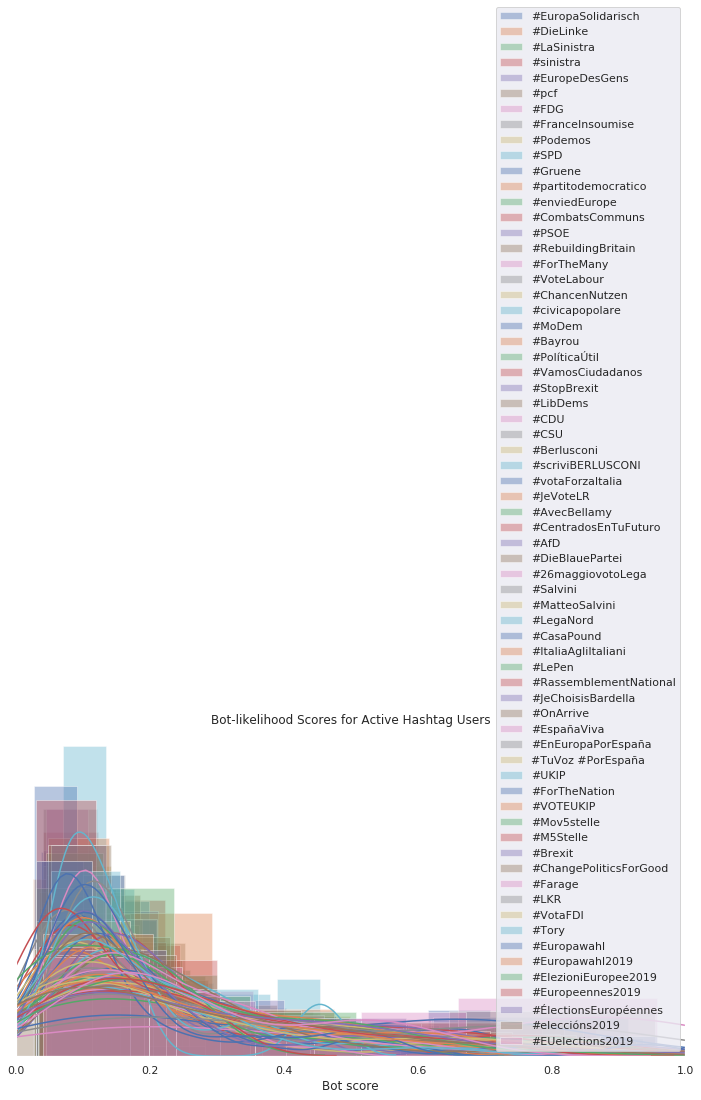

In [0]:
#this section iterates through hashtags, keeps information about where the hashtag is, and calls the giant function above

#this is the table that will have all of the hashtags and their categories to iterate over
groupings_hashtags = pd.read_csv('groupings_hashtags.csv', index_col = "leaning")

groupings_hashtags

#takes column headers
nations = list(groupings_hashtags)


for row in groupings_hashtags.itertuples():
  nationindex = -1
#   print(row)
  leaning = row.Index
  for nation in row[1:]:
    nationindex += 1
    election = nations[nationindex]
#     print(nation_name)
    if type(nation) != float and nation.isspace() == False:
#       print(nation)
      hashtags = nation.split(',')
      for hashtag in hashtags:
        hashtag = hashtag.strip()
        print(hashtag)
        print(leaning)
        #calls the giant function on every hashtag while preserving the details of that hashtag
        botdetectfunction(election, leaning, hashtag)

In [0]:
#total number of tweets collected
alltweets = pd.read_csv('EU_parliament_tweets_json.csv')
print("The total number of tweets collected is " + str(len(alltweets)))

ParserError: ignored